<a href="https://colab.research.google.com/github/leard/IA368X/blob/master/Process_and_Extract_Features_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configurações Iniciais


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Configuração dos caminhos

In [ ]:
PATH_CODEBASE=''
PATH_BRATS=''
PATH_TRAIN_DATASET=''
PATH_VALID_DATASET=''
PATH_TEST_DATASET=''

## Carregando e configurando locais

In [ ]:
import sys
sys.path.append(PATH_CODEBASE)

In [ ]:
from datasets.brats import BRATS
from utils.asserts import VALID_MODES
from matplotlib import pyplot as plt
from matplotlib import colors

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage.transform import rotate
from skimage.feature import local_binary_pattern

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import cross_val_score, GridSearchCV

from skimage import exposure
import numpy as np
import pandas as pd


from tqdm.notebook import tqdm

%matplotlib inline 

In [ ]:
BRATS.PATHS["2020"]["default"] = PATH_BRATS

In [ ]:
%%time
# # Não precisa mexer nos argumentos. brats vira um dicionário com as keys ["train", "validation", "test"]
# # Como acessar na célula embaixo
brats = {mode: BRATS(year="2020", 
                     release="default", 
                     group="all", 
                     mode=mode, 
                     sep_mode="holdout",
                     splits=(0.7, 0.1, 0.2), 
                     has_survival_only=True) for mode in VALID_MODES}

Reading survival only subjects from has_survival_2020_train.txt
Reading survival only subjects from has_survival_2020_train.txt
Reading survival only subjects from has_survival_2020_train.txt
CPU times: user 197 ms, sys: 163 ms, total: 360 ms
Wall time: 1min 4s


In [ ]:
lens = {mode: len(brats[mode]) for mode in VALID_MODES}
lens

{'test': 46, 'train': 169, 'validation': 21}

#Verificando Imagens

A função view_images é responsável por apresentar as imagens de RMI relacionadas aos cérebros e tumores segmentados em 4 diferentes modalidades

In [ ]:
def view_images(subject_id=1, slice=80):
    Nr = 2
    Nc = 4
    cmap = "gray"

    fig, axs = plt.subplots(Nr, Nc, figsize=(24, 12), subplot_kw={'xticks': [], 'yticks': []})
    fig.suptitle('Multiple images')

    labels = [['IMAGE T1', 'IMAGE T1Gd', 'IMAGE T2', 'IMAGE T2-FLAIR'], 
              ['TUMOR T1', 'TUMOR T1Gd', 'TUMOR T2', 'TUMOR T2-FLAIR']]

    images = []
    count = 0
    mri, target, _, _, _ = brats["train"][subject_id]
    for i in range(Nr):
        for j in range(Nc):
            if i == 0:
                images.append(axs[i, j].imshow(mri[j, :, :, slice], cmap=cmap))
            elif i == 1:
                images.append(axs[i, j].imshow(target[j, :, :, slice], cmap=cmap))
            axs[i, j].set_title(labels[i][j])

    # Normalizando visualizaçao
    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)

    fig.colorbar(images[0], ax=axs, orientation='vertical', fraction=.1)
    plt.show()


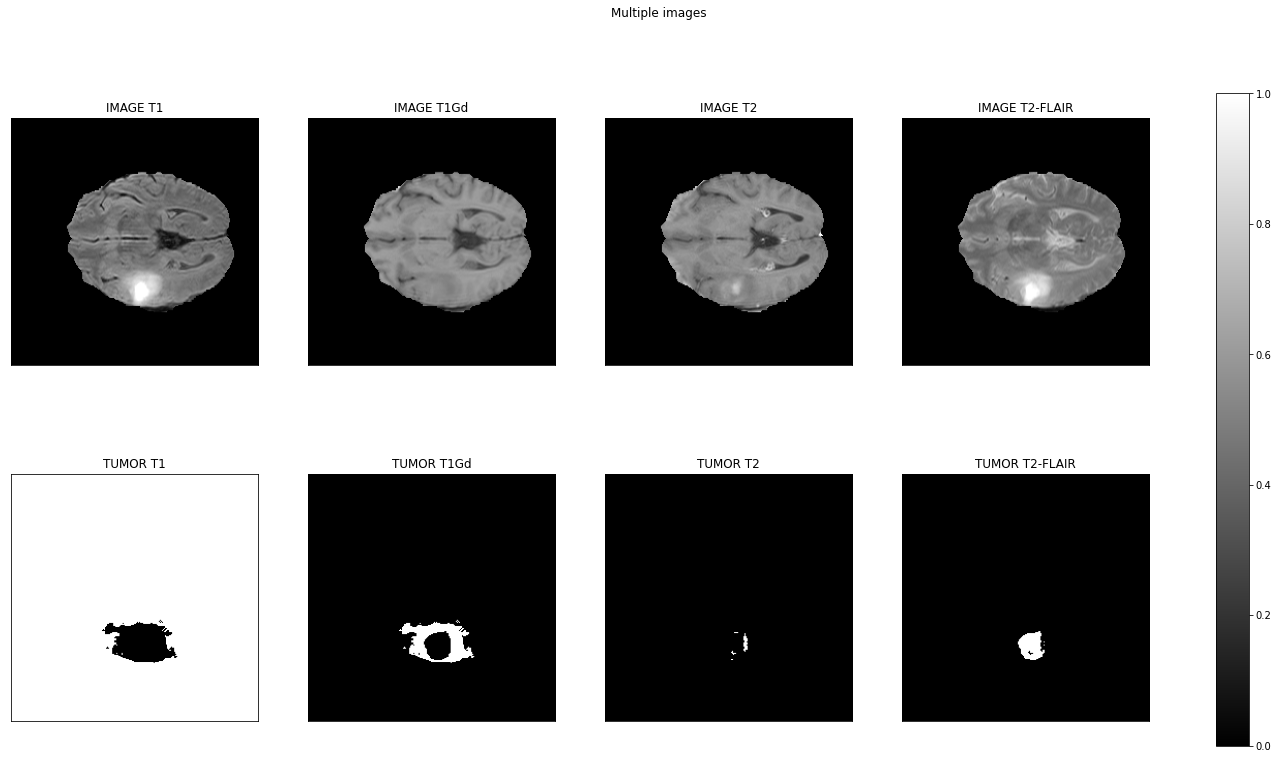

In [ ]:
#Verificando o corte 60 do sujeito com id 1
view_images(subject_id=1, slice=60)

#Histogram of Oriented Gradients (HOG)

In [ ]:
def hog_view(subject_id=1, 
             slice=60, 
             view_image=False,
             image_type=0,
             tumor_tissue='whole', 
             pixels_per_cell=(4,4), 
             cells_per_block=(2,2),             
             pca_value=None):
    
    mri, target, _, _, _ = brats["train"][subject_id]
    #
    tumor = tumor_slice = None

    if view_image:        
        tumor = mri[image_type]
    else:        
        if tumor_tissue == 'whole':
            mask = target[1:].sum(axis=0) == 0.0            
            tumor = mri[image_type]            
            tumor[mask] = 0.0  
        elif tumor_tissue == 'core':
            mask = target[2:].sum(axis=0) == 0.0            
            tumor = mri[image_type]            
            tumor[mask] = 0.0
            
    tumor_slice= tumor[:,:,slice]
    if pca_value is not None:
        pca = PCA(pca_value)
        tumor_slice = pca.fit_transform(tumor_slice)
        print(f'Image shape, after PCA: {tumor_slice.shape}')
        tumor_slice = pca.inverse_transform(tumor_slice)

    fd, hog_image = hog(tumor_slice, orientations=9, 
                        pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, visualize=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

    ax1.imshow(tumor_slice, cmap=plt.cm.gray) 
    ax1.set_title('Tumor Image')
    if view_image:
        ax1.set_title('Image of brain with tumor')

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 1)) 
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('Histogram of Oriented Gradients')

    plt.show()

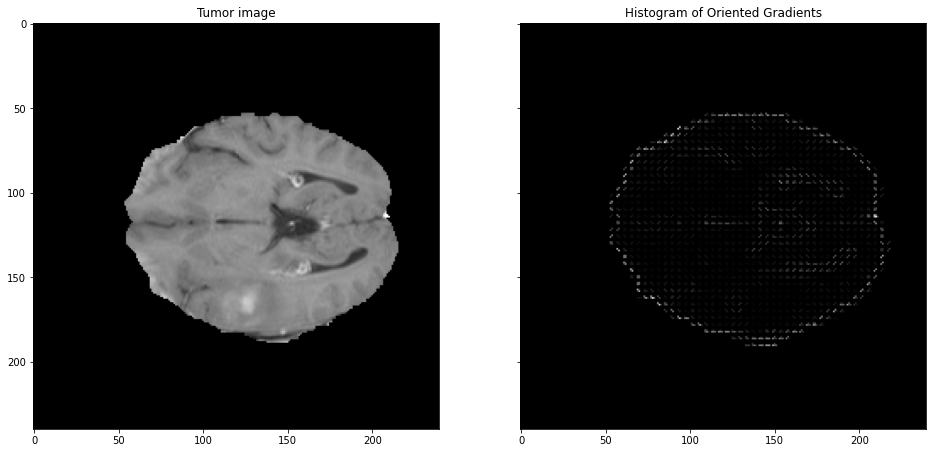

CPU times: user 3.5 s, sys: 35 ms, total: 3.54 s
Wall time: 3.57 s


In [ ]:
%%time
hog_view(subject_id=1, slice=60, view_image=True, image_type=2, pixels_per_cell=(4,4))

Image shape, after PCA: (240, 29)


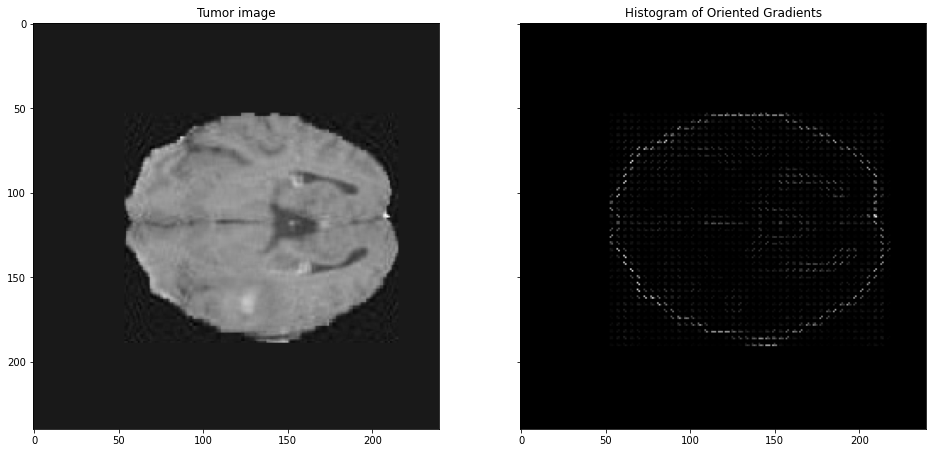

CPU times: user 3.61 s, sys: 169 ms, total: 3.78 s
Wall time: 3.65 s


In [ ]:
%%time
hog_view(subject_id=1, slice=60, view_image=True, image_type=2, pixels_per_cell=(4,4), pca_value=0.99)

Image shape, after PCA: (240, 7)


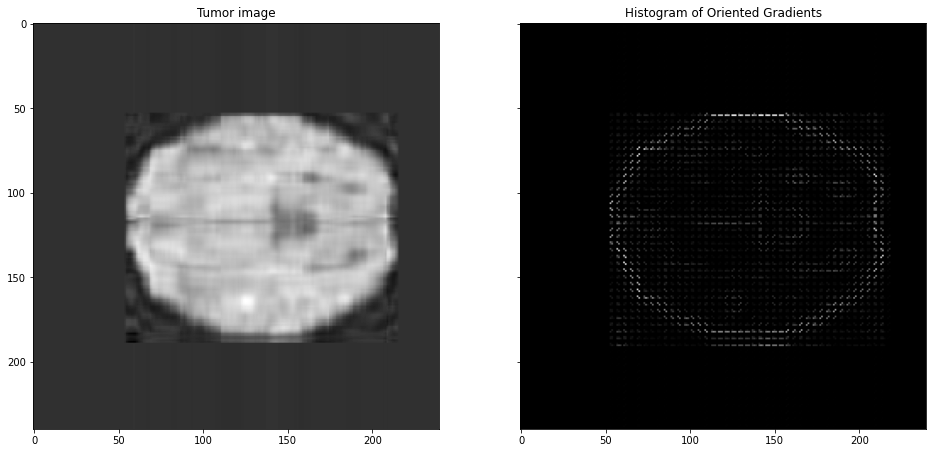

CPU times: user 3.57 s, sys: 141 ms, total: 3.71 s
Wall time: 3.58 s


In [ ]:
%%time
hog_view(subject_id=1, slice=60, view_image=True, image_type=2, pixels_per_cell=(4,4), pca_value=0.95)

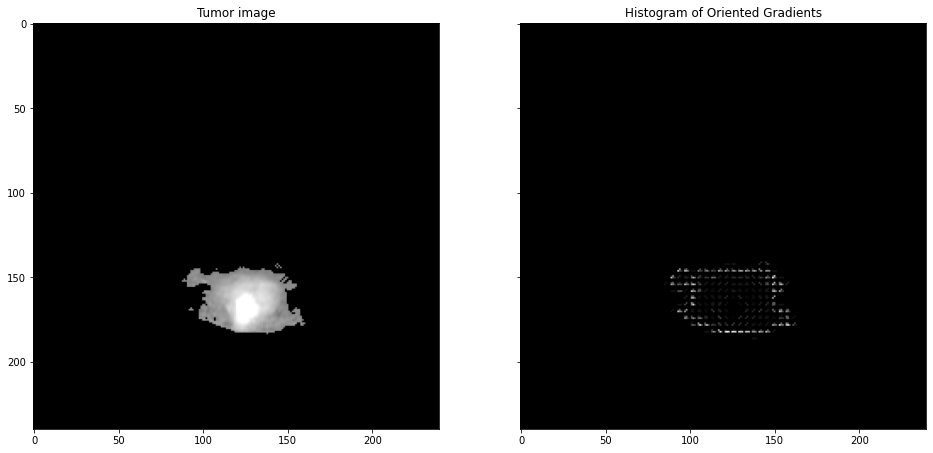

In [ ]:
hog_view(subject_id=1, slice=60, tumor_tissue='whole')

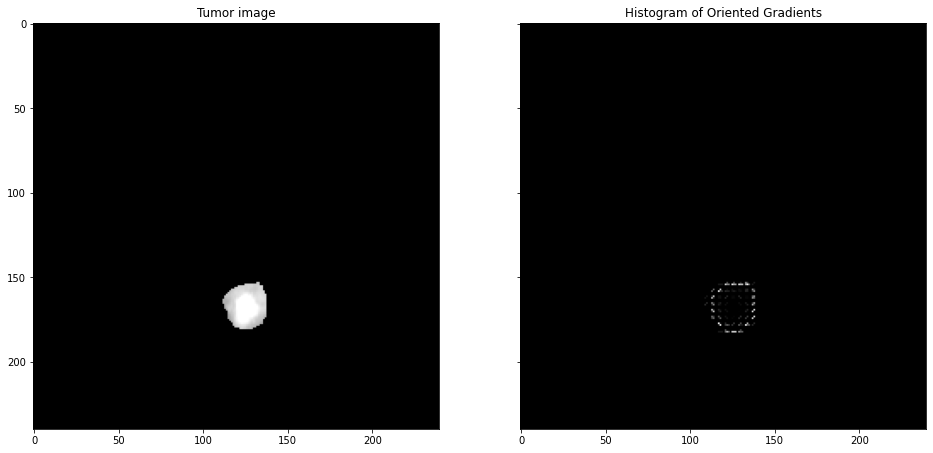

In [ ]:
hog_view(subject_id=1, slice=60, tumor_tissue='core', pixels_per_cell=(4,4))

In [ ]:
def hog_process_slices(tumor=None, 
                       axis=None,
                       pixels_per_cell=(8,8), 
                       cells_per_block=(2,2),
                       subject_id=None,
                       tumor_tissue=None,
                       image_type=0,
                       pca_value=None):
    
    #Somente para depuração
    if subject_id is not None and tumor_tissue is not None: 
        mri, target, _, _, _ = brats["train"][subject_id]
        if tumor_tissue == 'whole':
            mask = target[1:].sum(axis=0) == 0.0            
            tumor = mri[image_type]            
            tumor[mask] = 0.0  
        elif tumor_tissue == 'core':
            mask = target[2:].sum(axis=0) == 0.0            
            tumor = mri[image_type]            
            tumor[mask] = 0.0
    
    assert tumor.any()
    nslices = tumor.shape[-1]
    qt_zero = 0
    count = 0
    hog_subject = [] 
    pca = PCA(pca_value)
    for s in range(nslices):
        slic = tumor[:, :, s] # pega um slice
        
        if not np.isclose(slic.sum(), 0):
            if pca_value is not None:            
                slic = pca.fit_transform(slic)
                slic = pca.inverse_transform(slic)
             
            # calcula o hog de um slice
            fd = hog(slic, orientations=9, 
                     pixels_per_cell=pixels_per_cell, 
                     cells_per_block=cells_per_block, 
                     visualize=False) 
            hog_subject.append(fd.tolist()) # concatena a média do hog

    return np.mean(hog_subject, axis=axis)

In [ ]:
%%time
val = hog_process_slices(subject_id=0, axis=0, tumor_tissue='core')
print(val.shape)

(30276,)
CPU times: user 3.48 s, sys: 38.8 ms, total: 3.52 s
Wall time: 3.53 s


In [ ]:
%%time
val = hog_process_slices(subject_id=0, axis=0, tumor_tissue='core', pca_value=0.99)
print(val.shape)

(30276,)
CPU times: user 4.37 s, sys: 1.45 s, total: 5.82 s
Wall time: 4.44 s


In [ ]:
hist = np.histogram(val, bins=9)
hist

(array([29492,   158,   120,    73,    74,    84,   105,   126,    44]),
 array([0.        , 0.0683195 , 0.13663899, 0.20495849, 0.27327798,
        0.34159748, 0.40991697, 0.47823647, 0.54655597, 0.61487546]))

<BarContainer object of 9 artists>

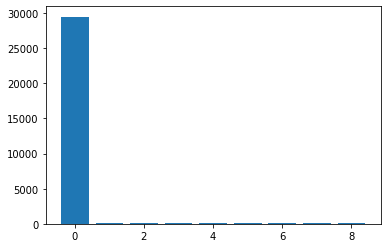

In [ ]:
plt.bar(x=range(len(hist[0])), height=hist[0])

In [ ]:
%%time
hog_process_slices(subject_id=10, axis=None, tumor_tissue='whole', image_type=3, pixels_per_cell=(4,4))

CPU times: user 8.38 s, sys: 170 ms, total: 8.55 s
Wall time: 8.56 s


0.002269300059004049

In [ ]:
%%time
hog_process_slices(subject_id=10, axis=None, tumor_tissue='whole', image_type=3, pixels_per_cell=(4,4), pca_value=0.99)

CPU times: user 13 s, sys: 5.82 s, total: 18.8 s
Wall time: 11.6 s


0.013096843185337746

In [ ]:
%%time
hog_process_slices(subject_id=10, axis=None, tumor_tissue='whole', image_type=3, pixels_per_cell=(4,4), pca_value=0.95)

CPU times: user 12.9 s, sys: 5.87 s, total: 18.8 s
Wall time: 11.7 s


0.012801316103789085

#Local Binary Pattern (LBP)

In [ ]:
def lbp_view(subject_id=1, 
             slice=60, 
             view_image=False,
             image_type=0,
             tumor_tissue='whole', 
             method='uniform',
             radius=3, 
             n_points=4,
             pca_value=None):
    
    # settings for LBP
    n_points = n_points * radius

    mri, target, _, _, _ = brats["train"][subject_id]
    #
    tumor = tumor_slice = None

    if view_image:        
        tumor = mri[image_type]
    else:        
        if tumor_tissue == 'whole':
            mask = target[1:].sum(axis=0) == 0.0
            tumor = mri[image_type]
            tumor[mask] = 0.0
        elif tumor_tissue == 'core':
            mask = target[2:].sum(axis=0) == 0.0
            tumor = mri[image_type]
            tumor[mask] = 0.0
            
    tumor_slice= tumor[:,:,slice]
    if pca_value is not None:
        pca = PCA(pca_value)
        tumor_slice = pca.fit_transform(tumor_slice)
        print(f'Image shape, after PCA: {tumor_slice.shape}')
        tumor_slice = pca.inverse_transform(tumor_slice)

    # values: default uniform ror nri_uniform var
    lbp = local_binary_pattern(tumor_slice, n_points, radius, method)

    #lbp[mask[:,:,slice]] = 0.0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

    ax1.imshow(tumor_slice, cmap=plt.cm.gray) 
    ax1.set_title('Tumor image') 
    
    ax2.imshow(lbp, cmap=plt.cm.gray) 
    ax2.set_title('Local Binary')

    plt.show()


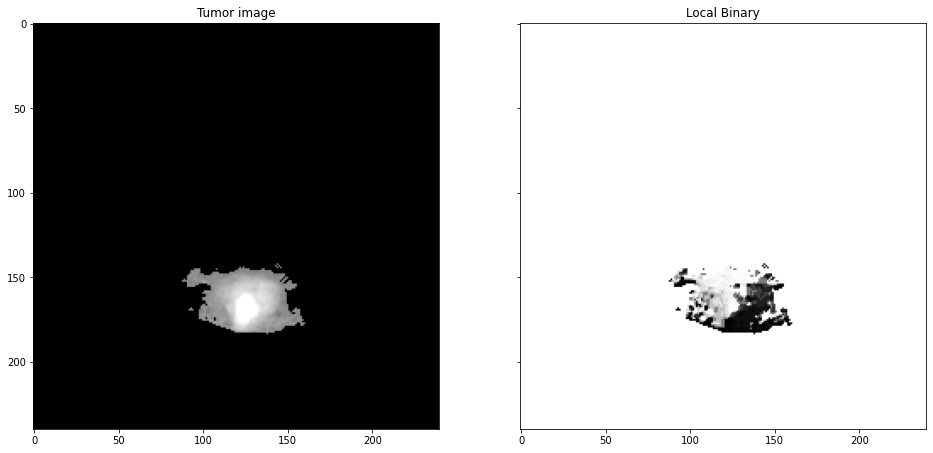

CPU times: user 3.1 s, sys: 26 ms, total: 3.13 s
Wall time: 3.14 s


In [ ]:
%%time
lbp_view(subject_id=1, slice=60, method='default', tumor_tissue='whole')

Image shape, after PCA: (240, 14)


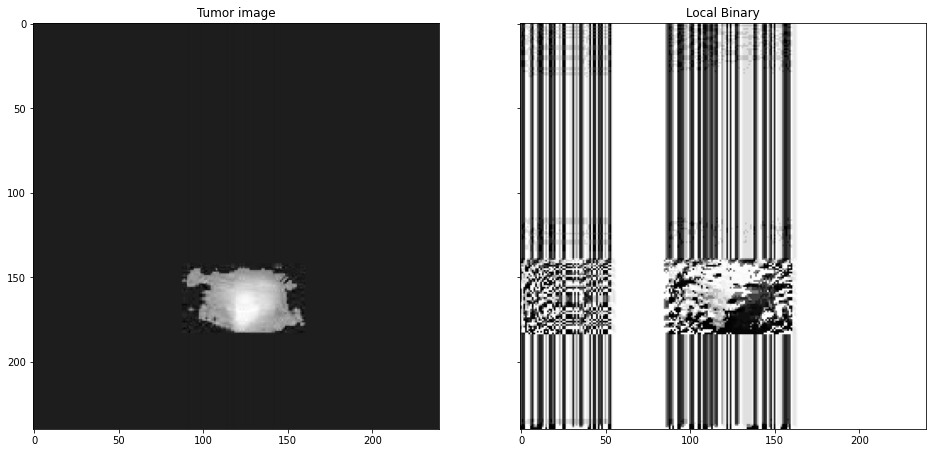

CPU times: user 3.01 s, sys: 140 ms, total: 3.15 s
Wall time: 3.03 s


In [ ]:
%%time
#Utilizando PCA
lbp_view(subject_id=1, slice=60, method='default', tumor_tissue='whole', pca_value=0.99)

Image shape, after PCA: (240, 4)


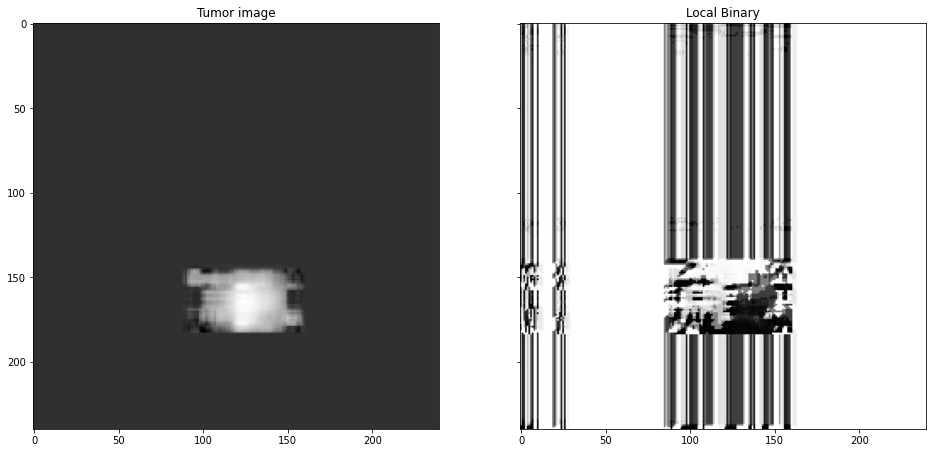

CPU times: user 3.01 s, sys: 122 ms, total: 3.14 s
Wall time: 3.03 s


In [ ]:
%%time
#Utilizando PCA
lbp_view(subject_id=1, slice=60, method='default', tumor_tissue='whole', pca_value=0.95)

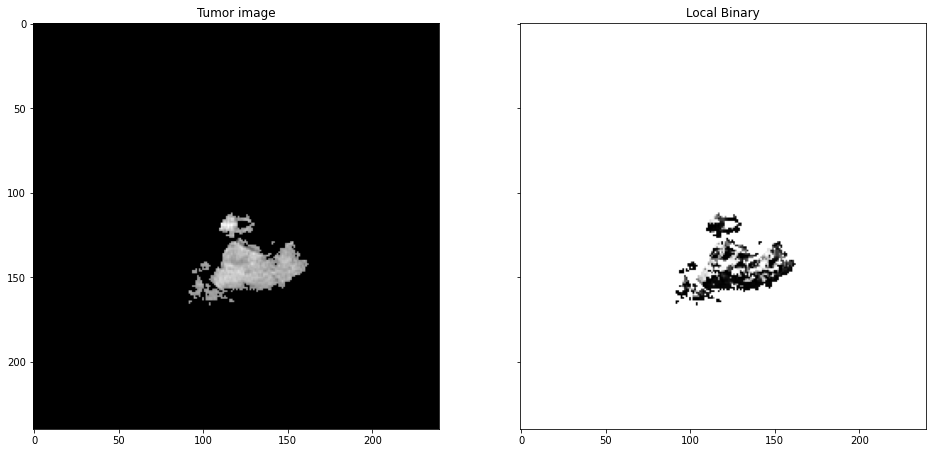

In [ ]:
lbp_view(subject_id=5, slice=60, method='default', tumor_tissue='whole')

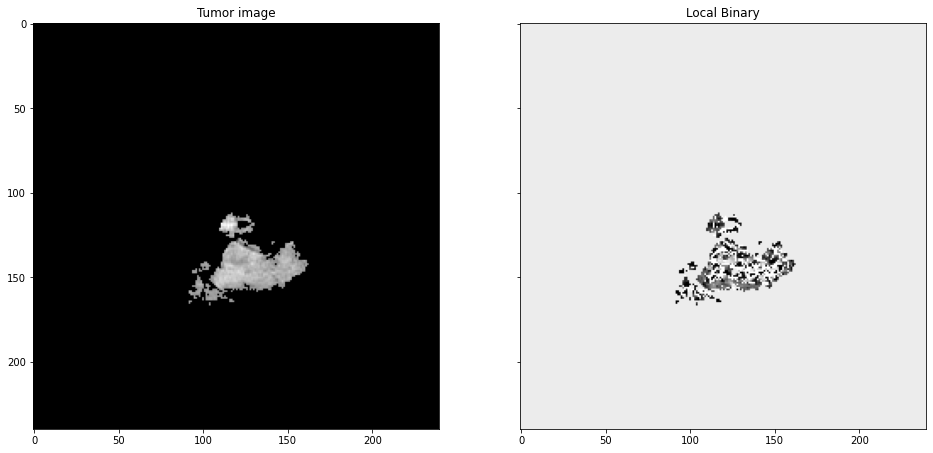

In [ ]:
lbp_view(subject_id=5, slice=60, method='uniform', tumor_tissue='whole')

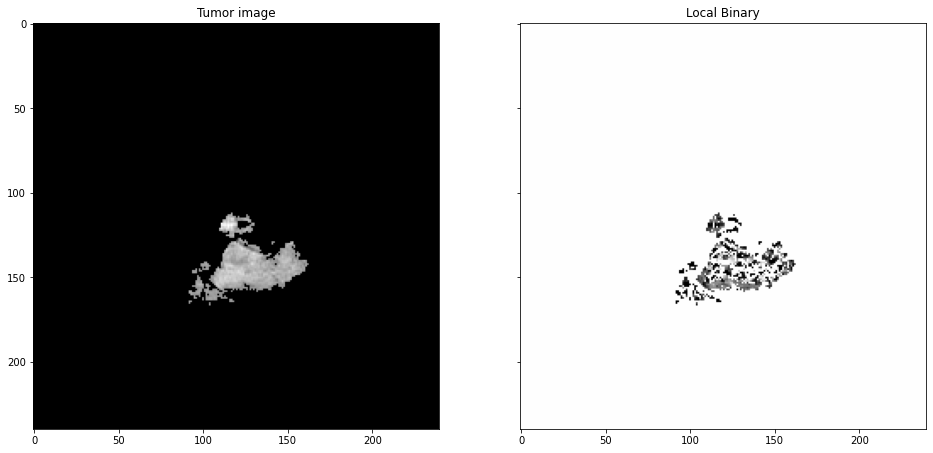

In [ ]:
lbp_view(subject_id=5, slice=60, method='nri_uniform', tumor_tissue='whole')

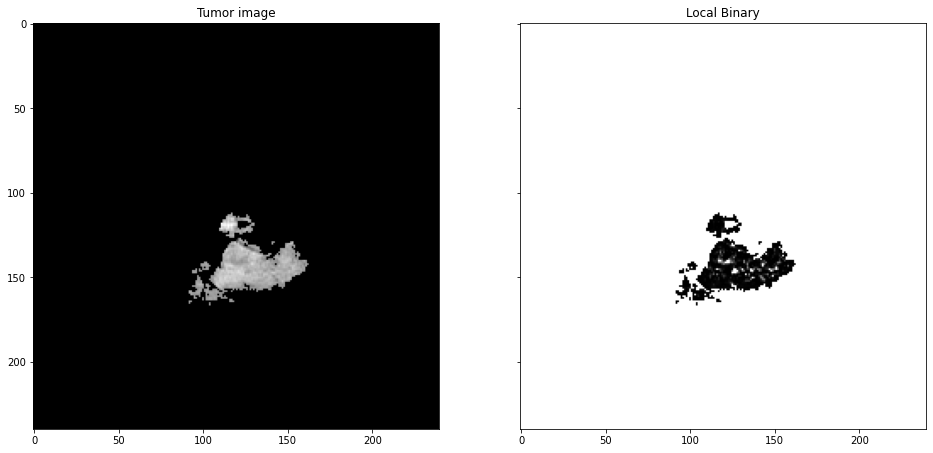

In [ ]:
lbp_view(subject_id=5, slice=60, method='ror', tumor_tissue='whole')

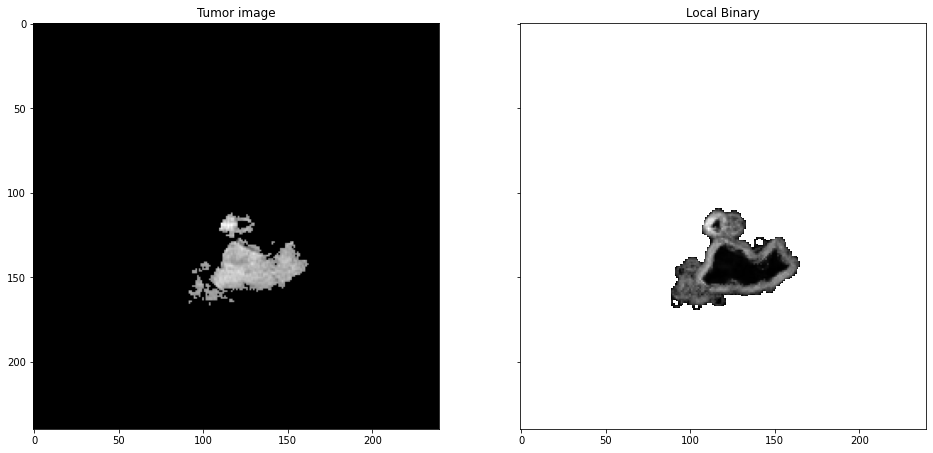

In [ ]:
lbp_view(subject_id=5, slice=60, method='var', tumor_tissue='whole')

In [ ]:
def lbp_process_slices(tumor=None, 
                       axis=None,
                       radius=3, 
                       n_points=4,
                       method='default',
                       subject_id=None,
                       tumor_tissue=None,
                       image_type=0,
                       pca_value=None):
    
    n_points = n_points*radius
    
    #Somente para depuração
    if subject_id is not None and tumor_tissue is not None: 
        mri, target, _, _, _ = brats["train"][subject_id]
        if tumor_tissue == 'whole':
            mask = target[1:].sum(axis=0) == 0.0            
            tumor = mri[image_type]            
            tumor[mask] = 0.0  
        elif tumor_tissue == 'core':
            mask = target[2:].sum(axis=0) == 0.0            
            tumor = mri[image_type]            
            tumor[mask] = 0.0
    
    assert tumor.any()
    nslices = tumor.shape[-1]
    qt_zero = 0
    count = 0
    hog_subject = [] 
    pca = PCA(pca_value)
    for s in range(nslices):
        slic = tumor[:, :, s] # pega um slice        
        if not np.isclose(slic.sum(), 0):
            if pca_value is not None:            
                slic = pca.fit_transform(slic)
                slic = pca.inverse_transform(slic)   
            # calcula o lbp  de um slice
            lbp = local_binary_pattern(slic, n_points, radius, method) 
            hog_subject.append(lbp.tolist()) 

    return np.mean(hog_subject, axis=axis)

In [ ]:
%%time
val = lbp_process_slices(subject_id=5, axis=0, tumor_tissue='core')
print(val.shape)

(240, 240)
CPU times: user 3.27 s, sys: 51.5 ms, total: 3.32 s
Wall time: 3.34 s


In [ ]:
%%time
#Utilizando PCA
val = lbp_process_slices(subject_id=5, axis=0, tumor_tissue='core', pca_value=0.99)
print(val.shape)

(240, 240)
CPU times: user 4.18 s, sys: 977 ms, total: 5.16 s
Wall time: 3.98 s


In [ ]:
hist = np.histogram(val, bins=9)
hist

(array([    1,     5,    32,   534,  2063,  4250,  4845,  5255, 40615]),
 array([   9.59259259,  463.52674897,  917.46090535, 1371.39506173,
        1825.32921811, 2279.26337449, 2733.19753086, 3187.13168724,
        3641.06584362, 4095.        ]))

<BarContainer object of 9 artists>

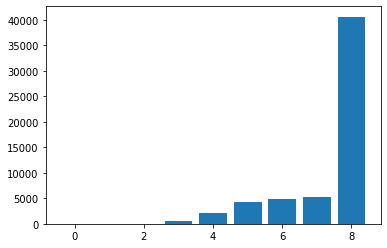

In [ ]:
plt.bar(x=range(len(hist[0])), height=hist[0])

In [ ]:
%%time
lbp_process_slices(subject_id=0, axis=None, tumor_tissue='core')

CPU times: user 3.03 s, sys: 39 ms, total: 3.07 s
Wall time: 3.08 s


4082.846129981884

In [ ]:
%%time
lbp_process_slices(subject_id=0, axis=None, tumor_tissue='core', pca_value=0.99)

CPU times: user 3.87 s, sys: 823 ms, total: 4.69 s
Wall time: 3.72 s


3721.5247765700483

In [ ]:
%%time
lbp_process_slices(subject_id=0, axis=None, tumor_tissue='core', pca_value=0.95)

CPU times: user 3.86 s, sys: 812 ms, total: 4.67 s
Wall time: 3.69 s


3815.9906944444447

# Extraindo caracteristicas das imagens

##get_features

In [ ]:
def get_features(dataset='train', 
                 pixels_per_cell=(8,8), 
                 radius=3, 
                 n_points=4,
                 pca_value=None):
    ages = []
    survivals=[]
    survivals_class=[]
    
    tumor_types = [0, 0]

    pac_whole_volume=[]
    pac_core_volume=[]
    
    hog_whole_list=[]
    hog_core_list=[]
    
    hog_whole_hist_list=[]
    hog_core_hist_list=[]

    lbp_whole_list=[]
    lbp_core_list=[]

    lbp_whole_hist_list=[]
    lbp_core_hist_list=[] 

    
    labels1= ['ages', 
              'survivals', 
              'survivals_class', 
              'vol_tumor_whole',
              'vol_tumor_core']

    labels2=[['hog_med_tumor_whole_1',
              'hog_med_tumor_whole_2',
              'hog_med_tumor_whole_3',
              'hog_med_tumor_whole_4'],
             ['hog_med_tumor_core_1',
              'hog_med_tumor_core_2',
              'hog_med_tumor_core_3',
              'hog_med_tumor_core_4'],
             ['lbp_med_tumor_whole_1',
              'lbp_med_tumor_whole_2',
              'lbp_med_tumor_whole_3',
              'lbp_med_tumor_whole_4'],
             ['lbp_med_tumor_core_1',
              'lbp_med_tumor_core_2',
              'lbp_med_tumor_core_3',
              'lbp_med_tumor_core_4']]
    
    labels3= ['hog_core_his_1_1',
              'hog_core_his_2_1',
              'hog_core_his_3_1',
              'hog_core_his_4_1',
              'hog_core_his_5_1',
              'hog_core_his_6_1',
              'hog_core_his_7_1',
              'hog_core_his_8_1',
              'hog_core_his_9_1',
              'hog_core_his_1_2',
              'hog_core_his_2_2',
              'hog_core_his_3_2',
              'hog_core_his_4_2',
              'hog_core_his_5_2',
              'hog_core_his_6_2',
              'hog_core_his_7_2',
              'hog_core_his_8_2',
              'hog_core_his_9_2',
              'hog_core_his_1_3',
              'hog_core_his_2_3',
              'hog_core_his_3_3',
              'hog_core_his_4_3',
              'hog_core_his_5_3',
              'hog_core_his_6_3',
              'hog_core_his_7_3',
              'hog_core_his_8_3',
              'hog_core_his_9_3',
              'hog_core_his_1_4',
              'hog_core_his_2_4',
              'hog_core_his_3_4',
              'hog_core_his_4_4',
              'hog_core_his_5_4',
              'hog_core_his_6_4',
              'hog_core_his_7_4',
              'hog_core_his_8_4',
              'hog_core_his_9_4']
                
    labels4= ['hog_whole_his_1_1',
              'hog_whole_his_2_1',
              'hog_whole_his_3_1',
              'hog_whole_his_4_1',
              'hog_whole_his_5_1',
              'hog_whole_his_6_1',
              'hog_whole_his_7_1',
              'hog_whole_his_8_1',
              'hog_whole_his_9_1',
              'hog_whole_his_1_2',
              'hog_whole_his_2_2',
              'hog_whole_his_3_2',
              'hog_whole_his_4_2',
              'hog_whole_his_5_2',
              'hog_whole_his_6_2',
              'hog_whole_his_7_2',
              'hog_whole_his_8_2',
              'hog_whole_his_9_2',
              'hog_whole_his_1_3',
              'hog_whole_his_2_3',
              'hog_whole_his_3_3',
              'hog_whole_his_4_3',
              'hog_whole_his_5_3',
              'hog_whole_his_6_3',
              'hog_whole_his_7_3',
              'hog_whole_his_8_3',
              'hog_whole_his_9_3',
              'hog_whole_his_1_4',
              'hog_whole_his_2_4',
              'hog_whole_his_3_4',
              'hog_whole_his_4_4',
              'hog_whole_his_5_4',
              'hog_whole_his_6_4',
              'hog_whole_his_7_4',
              'hog_whole_his_8_4',
              'hog_whole_his_9_4']
    
    labels5= ['lbp_core_his_1_1',
              'lbp_core_his_2_1',
              'lbp_core_his_3_1',
              'lbp_core_his_4_1',
              'lbp_core_his_5_1',
              'lbp_core_his_6_1',
              'lbp_core_his_7_1',
              'lbp_core_his_8_1',
              'lbp_core_his_9_1',
              'lbp_core_his_1_2',
              'lbp_core_his_2_2',
              'lbp_core_his_3_2',
              'lbp_core_his_4_2',
              'lbp_core_his_5_2',
              'lbp_core_his_6_2',
              'lbp_core_his_7_2',
              'lbp_core_his_8_2',
              'lbp_core_his_9_2',
              'lbp_core_his_1_3',
              'lbp_core_his_2_3',
              'lbp_core_his_3_3',
              'lbp_core_his_4_3',
              'lbp_core_his_5_3',
              'lbp_core_his_6_3',
              'lbp_core_his_7_3',
              'lbp_core_his_8_3',
              'lbp_core_his_9_3',
              'lbp_core_his_1_4',
              'lbp_core_his_2_4',
              'lbp_core_his_3_4',
              'lbp_core_his_4_4',
              'lbp_core_his_5_4',
              'lbp_core_his_6_4',
              'lbp_core_his_7_4',
              'lbp_core_his_8_4',
              'lbp_core_his_9_4']

    labels6 = ['lbp_whole_his_1_1',
              'lbp_whole_his_2_1',
              'lbp_whole_his_3_1',
              'lbp_whole_his_4_1',
              'lbp_whole_his_5_1',
              'lbp_whole_his_6_1',
              'lbp_whole_his_7_1',
              'lbp_whole_his_8_1',
              'lbp_whole_his_9_1',
              'lbp_whole_his_1_2',
              'lbp_whole_his_2_2',
              'lbp_whole_his_3_2',
              'lbp_whole_his_4_2',
              'lbp_whole_his_5_2',
              'lbp_whole_his_6_2',
              'lbp_whole_his_7_2',
              'lbp_whole_his_8_2',
              'lbp_whole_his_9_2',
              'lbp_whole_his_1_3',
              'lbp_whole_his_2_3',
              'lbp_whole_his_3_3',
              'lbp_whole_his_4_3',
              'lbp_whole_his_5_3',
              'lbp_whole_his_6_3',
              'lbp_whole_his_7_3',
              'lbp_whole_his_8_3',
              'lbp_whole_his_9_3',
              'lbp_whole_his_1_4',
              'lbp_whole_his_2_4',
              'lbp_whole_his_3_4',
              'lbp_whole_his_4_4',
              'lbp_whole_his_5_4',
              'lbp_whole_his_6_4',
              'lbp_whole_his_7_4',
              'lbp_whole_his_8_4',
              'lbp_whole_his_9_4']
    
    
    for subject in tqdm(range(len(brats[dataset]))):
        
        mri, target, tumor_type, age, survival = brats[dataset][subject]

        #Get subject data
        survivals.append(float(survival))        
        ages.append(float(age))
        tumor_types[tumor_type] += 1
        
        
        #Volume de todo o tumor 
        whole_tumor = target[1:].sum(axis=0)
        tumor_volume = whole_tumor.sum()
        pac_whole_volume.append(tumor_volume)

        #Volume do núcleo do tumor
        tumor_core = target[2:].sum(axis=0)
        core_volume = tumor_core.sum()
        pac_core_volume.append(core_volume)
        
        #List for data temp
        hog_whole_list_temp = []
        hog_whole_hist_list_temp = []
        hog_core_list_temp = []        
        hog_core_hist_list_temp = []

        lbp_whole_list_temp = []
        lbp_whole_hist_list_temp = []
        lbp_core_list_temp = []
        lbp_core_hist_list_temp = []

        #Mascaras para Whole Tumor
        mask_whole = target[1:].sum(axis=0) == 0.0
        #Mascaras para Tumor Core
        mask_core = target[2:].sum(axis=0) == 0.0

        for i in range(4):
            tumor_whole = mri[i]
            tumor_core = mri[i]
            tumor_whole[mask_whole] = 0.0
            tumor_core[mask_core] = 0.0 

            #Pegando os dados Médios HOG do Tumor completo
            hog_whole_list_temp.append(hog_process_slices(tumor_whole, 
                                                          axis=None, 
                                                          pixels_per_cell=pixels_per_cell,
                                                          pca_value=pca_value))

            #Pegando os dados distribuição HOG do Tumor completo
            hog_whole_hist, _ = np.histogram(hog_process_slices(tumor_whole, 
                                                                axis=0, 
                                                                pixels_per_cell=pixels_per_cell,
                                                                pca_value=pca_value), bins=9)
            # concatena histograma
            hog_whole_hist_list_temp.append(hog_whole_hist.tolist()) 

            #Pegando os dados Médios LBP do Tumor completo
            lbp_whole_list_temp.append(lbp_process_slices(tumor_whole, 
                                                          axis=None, 
                                                          radius=radius, 
                                                          n_points=n_points,
                                                          pca_value=pca_value))

            #Pegando os dados distribuição HOG do Tumor completo
            lbp_whole_hist, _ = np.histogram(lbp_process_slices(tumor_whole, 
                                                                axis=0, 
                                                                radius=radius, 
                                                                n_points=n_points,
                                                                pca_value=pca_value), bins=9) 
            # concatena histograma
            lbp_whole_hist_list_temp.append(lbp_whole_hist.tolist()) 

            #Pegando os dados Médios HOG Núcleo do Tumor
            hog_core_list_temp.append(hog_process_slices(tumor_core, 
                                                         axis=None, 
                                                         pixels_per_cell=pixels_per_cell,
                                                         pca_value=pca_value))

            #Pegando os dados distribuição HOG Núcleo do Tumor
            hog_core_hist, _ = np.histogram(hog_process_slices(tumor_core, 
                                                               axis=0, 
                                                               pixels_per_cell=pixels_per_cell,
                                                               pca_value=pca_value), bins=9) 
            # concatena histograma
            hog_core_hist_list_temp.append(hog_core_hist.tolist()) 

            #Pegando os dados Médios LBP do Núcleo Tumor
            lbp_core_list_temp.append(lbp_process_slices(tumor_core, 
                                                         axis=None, 
                                                         radius=radius, 
                                                         n_points=n_points,
                                                         pca_value=pca_value))

            #Pegando os dados distribuição LBP do Núcleo Tumor
            lbp_core_hist, _ = np.histogram(lbp_process_slices(tumor_core, 
                                                               axis=0, 
                                                               radius=radius, 
                                                               n_points=n_points,
                                                               pca_value=pca_value), bins=9) 
            # concatena histograma
            lbp_core_hist_list_temp.append(lbp_core_hist.tolist())

        #Setting the list for features in each image
        #HOG Feature
        hog_whole_list.append(hog_whole_list_temp)
        hog_whole_hist_list.append(np.concatenate(hog_whole_hist_list_temp, 
                                                  axis=0))
        hog_core_list.append(hog_core_list_temp)
        hog_core_hist_list.append(np.concatenate(hog_core_hist_list_temp, 
                                                 axis=0))
        #LBP Feature
        lbp_whole_list.append(lbp_whole_list_temp)
        lbp_whole_hist_list.append(np.concatenate(lbp_whole_hist_list_temp, 
                                                  axis=0))
        lbp_core_list.append(lbp_core_list_temp)
        lbp_core_hist_list.append(np.concatenate(lbp_core_hist_list_temp, 
                                                 axis=0))
        

        # Data of Survive
        if survival < 300:
            survivals_class.append(0)
        elif survival >= 300 and survival < 450 :
            survivals_class.append(1)
        else:
            survivals_class.append(2)
        
        #End of Loop
    
    features = pd.DataFrame(columns=labels1)
    features.ages = ages    
    features.survivals = survivals   
    features.survivals_class = survivals_class    
    features.vol_tumor_whole = pac_whole_volume
    features.vol_tumor_core = pac_core_volume
    
    #List data (HOG Average)
    features = pd.concat( [features, pd.DataFrame(hog_whole_list, 
                                                  columns=labels2[0])], axis=1)
    features = pd.concat( [features, pd.DataFrame(hog_core_list, 
                                                  columns=labels2[1])], axis=1)
    #List data (LBP Average)
    features = pd.concat( [features, pd.DataFrame(lbp_whole_list, 
                                                  columns=labels2[2])], axis=1)
    features = pd.concat( [features, pd.DataFrame(lbp_core_list, 
                                                  columns=labels2[3])], axis=1)
    
    #List data (HOG Histogram)
    features = pd.concat( [features, pd.DataFrame(hog_core_hist_list, 
                                                  columns=labels3)], axis=1) 
    features = pd.concat( [features, pd.DataFrame(hog_whole_hist_list, 
                                                  columns=labels4)], axis=1)
    #List data (LBP Histogram)
    features = pd.concat( [features, pd.DataFrame(lbp_core_hist_list, 
                                                  columns=labels5)], axis=1) 
    features = pd.concat( [features, pd.DataFrame(lbp_whole_hist_list, 
                                                  columns=labels6)], axis=1)

    
    return features

## Configurações de dataset

Versão 0: pixels_per_cell=(8,8), radius=3, n_points=8, sem PCA

Versão 1: pixels_per_cell=(8,8), radius=3, n_points=3*3, sem PCA

Versão 2: pixels_per_cell=(4,4), radius=3, n_points=4*3, sem PCA


In [ ]:
train_features = get_features('train',  pixels_per_cell=(8,8), radius=3, n_points=3)

In [ ]:
train_features.to_csv(PATH_TRAIN_DATASET+'train-1.csv')

In [ ]:
validation_features = get_features('validation',  pixels_per_cell=(8,8), radius=3, n_points=3)

In [ ]:
validation_features.to_csv(PATH_VALID_DATASET+'valid-1.csv')

In [ ]:
test_features = get_features('test',  pixels_per_cell=(8,8), radius=3, n_points=3)

In [ ]:
test_features.to_csv(PATH_TEST_DATASET+'test-1.csv')

# Avaliação Dataset 0

In [ ]:
train_features = pd.read_csv(PATH_TRAIN_DATASET+'train.csv')
validation_features = pd.read_csv(PATH_VALID_DATASET+'valid.csv')
test_features = pd.read_csv(PATH_TEST_DATASET+'tesT.csv')

In [ ]:
train_features.head()

,Unnamed: 0,ages,survivals,survivals_class,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,0,46.258,448.0,1,10101.0,6295.0,0.001830,0.001822,0.001947,0.001919,0.001830,0.001822,0.001947,0.001919,254.277597,254.261984,254.271156,254.262309,254.277597,254.261984,254.271156,254.262309,29965,90,75,53,43,27,9,10,4,29976,109,68,50,26,26,12,8,1,...,81,51,41,57165,9,36,44,65,85,69,51,60,57181,13,30,50,79,121,72,46,47,57142,12,43,67,80,86,74,43,36,57159,5,20,58,68,111,81,51,41,57165
1,1,57.362,508.0,2,58817.0,21750.0,0.002424,0.002362,0.002496,0.002509,0.002424,0.002362,0.002496,0.002509,253.648702,253.484994,253.550032,253.550037,253.648702,253.484994,253.550032,253.550037,29876,155,93,50,46,27,20,4,5,29885,150,97,38,45,27,23,6,5,...,158,155,107,56686,25,51,86,172,146,172,161,94,56693,11,61,85,115,185,188,148,127,56680,11,52,109,150,162,146,112,109,56749,12,53,100,159,170,158,155,107,56686
2,2,77.337,522.0,2,83418.0,7635.0,0.001837,0.001743,0.001909,0.001829,0.001837,0.001743,0.001909,0.001829,254.235882,254.265417,254.225119,254.199928,254.235882,254.265417,254.225119,254.199928,29976,95,78,54,36,16,14,4,3,30029,60,64,47,31,21,15,6,3,...,98,81,93,57121,11,36,48,76,61,77,73,91,57127,4,30,76,90,95,103,66,40,57096,10,31,56,80,88,103,65,36,57131,8,19,40,65,75,98,81,93,57121
3,3,57.718,229.0,0,171454.0,48395.0,0.005081,0.004903,0.004978,0.004951,0.005081,0.004903,0.004978,0.004951,252.112788,251.944466,252.035286,252.142578,252.112788,251.944466,252.035286,252.142578,29176,326,383,212,88,55,23,7,6,29253,375,319,160,70,63,21,8,7,...,333,317,257,55837,7,44,146,306,435,402,299,194,55767,5,76,228,367,438,408,253,122,55703,12,71,213,399,477,386,184,118,55740,21,115,211,236,273,333,317,257,55837
4,4,70.652,996.0,2,36221.0,7813.0,0.001602,0.001553,0.001674,0.001559,0.001602,0.001553,0.001674,0.001559,254.337624,254.352242,254.355340,254.342937,254.337624,254.352242,254.355340,254.342937,30004,109,54,43,23,25,11,4,3,30045,83,32,44,30,23,13,3,3,...,53,57,58,57205,6,20,40,62,90,80,58,40,57204,10,47,75,74,80,67,39,32,57176,8,19,38,57,93,94,53,43,57195,7,17,50,74,79,53,57,58,57205


In [ ]:
validation_features.head()

,Unnamed: 0,ages,survivals,survivals_class,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,0,51.734,359.0,1,80396.0,27568.0,0.004105,0.003907,0.004307,0.004114,0.004105,0.003907,0.004307,0.004114,253.011548,252.924034,252.990877,253.060810,253.011548,252.924034,252.990877,253.060810,29305,392,241,144,106,48,26,9,5,29460,286,166,152,115,56,25,9,7,...,294,297,294,55982,10,35,110,222,270,361,322,297,55973,8,20,59,184,347,451,377,246,55908,16,27,95,185,273,442,394,243,55925,16,58,180,234,245,294,297,294,55982
1,1,58.030,334.0,1,43342.0,25950.0,0.003581,0.003400,0.003644,0.003582,0.003581,0.003400,0.003644,0.003582,253.411743,253.131692,253.226863,253.236189,253.411743,253.131692,253.226863,253.236189,29321,404,264,133,83,40,22,8,1,29469,347,212,125,66,35,15,6,1,...,264,354,370,56188,10,24,78,94,147,334,411,375,56127,12,54,95,169,225,326,454,258,56007,13,36,77,193,309,389,342,205,56036,13,41,72,118,180,264,354,370,56188
2,2,44.449,199.0,0,80769.0,26245.0,0.003011,0.002924,0.003155,0.003023,0.003011,0.002924,0.003155,0.003023,253.298722,253.451274,253.388762,253.249333,253.298722,253.451274,253.388762,253.249333,29636,246,163,93,68,39,17,9,5,29658,253,146,89,62,38,17,8,5,...,266,248,235,56339,13,33,68,123,243,294,236,240,56350,7,19,52,111,225,299,254,235,56398,26,30,53,131,211,254,237,241,56417,16,35,77,141,243,266,248,235,56339
3,3,86.274,21.0,0,79531.0,61963.0,0.004909,0.004627,0.004992,0.004791,0.004909,0.004627,0.004992,0.004791,252.144598,252.066295,252.162136,252.067239,252.144598,252.066295,252.162136,252.067239,29183,358,305,211,124,63,25,6,1,29275,390,263,149,109,54,22,8,6,...,313,312,222,55726,41,148,239,319,345,320,259,204,55725,35,116,243,362,447,349,403,205,55440,54,157,267,259,338,356,438,259,55472,17,114,243,303,350,313,312,222,55726
4,4,53.605,466.0,2,99909.0,7897.0,0.001874,0.001758,0.001835,0.001823,0.001874,0.001758,0.001835,0.001823,254.440738,254.403863,254.454385,254.461687,254.440738,254.403863,254.454385,254.461687,29693,224,155,93,62,28,14,5,2,29802,146,117,99,62,29,12,7,2,...,127,139,184,56855,28,43,55,100,107,132,125,159,56851,5,20,41,70,114,162,178,158,56852,8,14,17,30,96,165,209,164,56897,6,25,49,86,129,127,139,184,56855


## Configurando os dados de treino, validação e teste

In [ ]:
x_train = train_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_train = train_features['survivals_class'].astype('category')

In [ ]:
x_train.head()

,ages,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,hog_core_his_1_3,hog_core_his_2_3,hog_core_his_3_3,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,46.258,10101.0,6295.0,0.001830,0.001822,0.001947,0.001919,0.001830,0.001822,0.001947,0.001919,254.277597,254.261984,254.271156,254.262309,254.277597,254.261984,254.271156,254.262309,29965,90,75,53,43,27,9,10,4,29976,109,68,50,26,26,12,8,1,29930,94,84,...,81,51,41,57165,9,36,44,65,85,69,51,60,57181,13,30,50,79,121,72,46,47,57142,12,43,67,80,86,74,43,36,57159,5,20,58,68,111,81,51,41,57165
1,57.362,58817.0,21750.0,0.002424,0.002362,0.002496,0.002509,0.002424,0.002362,0.002496,0.002509,253.648702,253.484994,253.550032,253.550037,253.648702,253.484994,253.550032,253.550037,29876,155,93,50,46,27,20,4,5,29885,150,97,38,45,27,23,6,5,29843,161,104,...,158,155,107,56686,25,51,86,172,146,172,161,94,56693,11,61,85,115,185,188,148,127,56680,11,52,109,150,162,146,112,109,56749,12,53,100,159,170,158,155,107,56686
2,77.337,83418.0,7635.0,0.001837,0.001743,0.001909,0.001829,0.001837,0.001743,0.001909,0.001829,254.235882,254.265417,254.225119,254.199928,254.235882,254.265417,254.225119,254.199928,29976,95,78,54,36,16,14,4,3,30029,60,64,47,31,21,15,6,3,29951,95,92,...,98,81,93,57121,11,36,48,76,61,77,73,91,57127,4,30,76,90,95,103,66,40,57096,10,31,56,80,88,103,65,36,57131,8,19,40,65,75,98,81,93,57121
3,57.718,171454.0,48395.0,0.005081,0.004903,0.004978,0.004951,0.005081,0.004903,0.004978,0.004951,252.112788,251.944466,252.035286,252.142578,252.112788,251.944466,252.035286,252.142578,29176,326,383,212,88,55,23,7,6,29253,375,319,160,70,63,21,8,7,29227,360,342,...,333,317,257,55837,7,44,146,306,435,402,299,194,55767,5,76,228,367,438,408,253,122,55703,12,71,213,399,477,386,184,118,55740,21,115,211,236,273,333,317,257,55837
4,70.652,36221.0,7813.0,0.001602,0.001553,0.001674,0.001559,0.001602,0.001553,0.001674,0.001559,254.337624,254.352242,254.355340,254.342937,254.337624,254.352242,254.355340,254.342937,30004,109,54,43,23,25,11,4,3,30045,83,32,44,30,23,13,3,3,29989,99,68,...,53,57,58,57205,6,20,40,62,90,80,58,40,57204,10,47,75,74,80,67,39,32,57176,8,19,38,57,93,94,53,43,57195,7,17,50,74,79,53,57,58,57205


In [ ]:
y_train.value_counts()

0    64
2    60
1    45
Name: survivals_class, dtype: int64

In [ ]:
y_train.head()

0    1
1    2
2    2
3    0
4    2
Name: survivals_class, dtype: category
Categories (3, int64): [0, 1, 2]

In [ ]:
x_valid = validation_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_valid = validation_features['survivals_class'].astype('category')

In [ ]:
y_valid.head()

0    1
1    1
2    0
3    0
4    2
Name: survivals_class, dtype: category
Categories (3, int64): [0, 1, 2]

In [ ]:
y_valid.value_counts()

0    10
2     8
1     3
Name: survivals_class, dtype: int64

In [ ]:
x_test = test_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_test = test_features['survivals_class'].astype('category')

In [ ]:
y_test.value_counts()

2    19
0    15
1    12
Name: survivals_class, dtype: int64

## Normalizando os dados

In [ ]:
scaler = StandardScaler()
# Fit somente nos dados de treino
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
x_train_scaled = scaler.transform(x_train)

In [ ]:
x_valid_scaled = scaler.transform(x_valid)

In [ ]:
x_test_scaled = scaler.transform(x_test)

##SVC Model

In [ ]:
# Configurando parametros para o grid-search
params_grid_SVC = [{'kernel': ['rbf', 'poly'], 
                    'gamma': ['auto', 1e-3, 1e-4, 1e-5], 
                    'C': [1, 10, 100], 
                    'degree': [1, 2, 3, 4], 
                    'probability': [True, False], 
                    'decision_function_shape': ['ovr'],
                    'break_ties': [True], 
                    'random_state': [1964],
                    'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
svc_model = GridSearchCV(SVC(), params_grid_SVC, cv=20, n_jobs=2)

In [ ]:
svc_model.fit(x_train_scaled, y_train)

[LibSVM]

GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None,

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', svc_model.best_score_,"\n")

Best score for training data: 0.5194444444444445 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best C:',svc_model.best_estimator_.C,"\n") 
print('Best Kernel:',svc_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svc_model.best_estimator_.gamma,"\n")
print('Best Degree:',svc_model.best_estimator_.degree,"\n")
print('Best Probability:',svc_model.best_estimator_.probability,"\n")

Best C: 10 

Best Kernel: rbf 

Best Gamma: auto 

Best Degree: 1 

Best Probability: True 



In [ ]:
final_model = svc_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print("Confusion Matrix\n")
print(confusion_matrix(y_valid, y_pred))
print("Classification Report\n")
print(classification_report(y_valid, y_pred))

print("Training set score for SVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for SVM: %f" % final_model.score(x_valid_scaled , y_valid))

svc_model.score

Confusion Matrix

[[8 1 1]
 [2 0 1]
 [0 4 4]]
Classification Report

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.00      0.00      0.00         3
           2       0.67      0.50      0.57         8

    accuracy                           0.57        21
   macro avg       0.49      0.43      0.46        21
weighted avg       0.63      0.57      0.60        21

Training set score for SVM: 0.934911
Validation set score for SVM: 0.571429


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

##NU SVC Model

Configurando parâmetros de grid-search

In [ ]:
# Configurando parametros para o grid-search
params_grid_NU_SVC = [{'kernel': ['rbf', 'poly'], 
                       'gamma': ['auto', 'scale',1e-3, 1e-4, 1e-5, 1e-6], 
                       'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                       'degree': [1, 2, 3, 4], 
                       'probability': [True, False], 
                       'decision_function_shape': ['ovr'],
                       'break_ties': [True], 
                       'random_state': [1964],
                       'verbose': [1]}]

In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
nu_svc_model = GridSearchCV(NuSVC(), params_grid_NU_SVC, cv=20, n_jobs=2)

In [ ]:
nu_svc_model.fit(x_train_scaled, y_train)

[LibSVM]

GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', nu_svc_model.best_score_,"\n")

Best score for training data: 0.5319444444444444 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best Kernel:',nu_svc_model.best_estimator_.kernel,"\n")
print('Best Gamma:',nu_svc_model.best_estimator_.gamma,"\n")
print('Best nu:',nu_svc_model.best_estimator_.nu,"\n")
print('Best Degree:',nu_svc_model.best_estimator_.degree,"\n")
print('Best Probability:',nu_svc_model.best_estimator_.probability,"\n")

Best Kernel: rbf 

Best Gamma: auto 

Best nu: 0.5 

Best Degree: 1 

Best Probability: True 



In [ ]:
final_model = nu_svc_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print("Confusion Matrix\n")
print(confusion_matrix(y_valid, y_pred))
print("Classification Report\n")
print(classification_report(y_valid, y_pred))

print("Training set score for nuSVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for nuSVM: %f" % final_model.score(x_valid_scaled , y_valid))

nu_svc_model.score

Confusion Matrix

[[8 1 1]
 [2 0 1]
 [1 4 3]]
Classification Report

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.00      0.00      0.00         3
           2       0.60      0.38      0.46         8

    accuracy                           0.52        21
   macro avg       0.44      0.39      0.41        21
weighted avg       0.57      0.52      0.54        21

Training set score for nuSVM: 0.905325
Validation set score for nuSVM: 0.523810


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
     

##PassiveAggressiveClassifier

Configurando parâmetros de grid-search

In [ ]:
# Configurando parametros para o grid-search
params_grid_PAC = [{'C': [1, 10, 100], 
                    'max_iter': [1000, 2000, 5000, 10000], 
                    'early_stopping': [True],                      
                    'loss': ['hinge', 'squared_hinge'],
                    'n_jobs': [2],
                    'random_state': [1964],
                    'verbose': [1]}]

In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
pac_classifier_model = GridSearchCV(PassiveAggressiveClassifier(), params_grid_PAC, cv=20, n_jobs=2)

In [ ]:
pac_classifier_model.fit(x_train_scaled, y_train)

-- Epoch 1-- Epoch 1
Norm: 0.72, NNZs: 163, Bias: -0.422864, T: 152, Avg. loss: 0.964697
Total training time: 0.00 seconds.

Norm: 0.77, NNZs: 163, Bias: -0.111458, T: 152, Avg. loss: 0.981330
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.85, NNZs: 163, Bias: -0.550116, T: 304, Avg. loss: 0.736449
Total training time: 0.00 seconds.
-- Epoch 2
-- Epoch 3
Norm: 1.08, NNZs: 163, Bias: -0.280489, T: 304, Avg. loss: 0.837128
Total training time: 0.01 seconds.
Norm: 1.11, NNZs: 163, Bias: -0.567229, T: 456, Avg. loss: 0.713225
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 1.29, NNZs: 163, Bias: -0.593560, T: 608, Avg. loss: 0.760757
Total training time: 0.01 seconds.
-- Epoch 3-- Epoch 5

Norm: 1.44, NNZs: 163, Bias: -0.666397, T: 760, Avg. loss: 0.710577
Total training time: 0.01 seconds.
Norm: 1.26, NNZs: 163, Bias: -0.317339, T: 456, Avg. loss: 0.771697
-- Epoch 6
Total training time: 0.01 seconds.
Norm: 1.58, NNZs: 163, Bias: -0.686449, T: 912, Avg. loss: 0.701109
Total tra

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.0s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'early_stopping': [Tr

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', pac_classifier_model.best_score_,"\n")

Best score for training data: 0.4138888888888889 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best learning_rate:',pac_classifier_model.best_estimator_.C,"\n") 
print('Best loss:',pac_classifier_model.best_estimator_.loss,"\n")
print('Best n_estimators:',pac_classifier_model.best_estimator_.max_iter,"\n")

Best learning_rate: 1 

Best loss: hinge 

Best n_estimators: 1000 



In [ ]:
final_model = pac_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for PassiveAggressiveClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for PassiveAggressiveClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

pac_classifier_model.score

[[6 3 1]
 [3 0 0]
 [1 5 2]]


              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.00      0.00      0.00         3
           2       0.67      0.25      0.36         8

    accuracy                           0.38        21
   macro avg       0.42      0.28      0.32        21
weighted avg       0.54      0.38      0.42        21

Training set score for PassiveAggressiveClassifier: 0.668639
Testing  set score for PassiveAggressiveClassifier: 0.380952


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C':

##RandomForest


In [ ]:
# Configurando parametros para o grid-search
params_grid_RF = [{'n_estimators': [100, 200, 300], 
                    'criterion': ['gini', 'entropy'], 
                    'max_depth': [None, 10, 15],                      
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'n_jobs': [2],
                    'random_state': [1964],
                    'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
rf_classifier_model = GridSearchCV(RandomForestClassifier(), params_grid_RF, cv=20, n_jobs=2)

In [ ]:
rf_classifier_model.fit(x_train_scaled, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.6s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', rf_classifier_model.best_score_,"\n")

Best score for training data: 0.5027777777777778 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best n_estimators:',rf_classifier_model.best_estimator_.n_estimators,"\n") 
print('Best criterion:',rf_classifier_model.best_estimator_.criterion,"\n")
print('Best max_depth:',rf_classifier_model.best_estimator_.max_depth,"\n")
print('Best max_features:',rf_classifier_model.best_estimator_.max_features,"\n")

Best n_estimators: 300 

Best criterion: gini 

Best max_depth: None 

Best max_features: log2 



In [ ]:
final_model = rf_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished


In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for RandomForestClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for RandomForestClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

rf_classifier_model.score

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


[[7 0 3]
 [2 0 1]
 [4 2 2]]


              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.00      0.00      0.00         3
           2       0.33      0.25      0.29         8

    accuracy                           0.43        21
   macro avg       0.29      0.32      0.30        21
weighted avg       0.38      0.43      0.40        21



[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


Training set score for RandomForestClassifier: 1.000000
Testing  set score for RandomForestClassifier: 0.428571


[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
              

##LogistcRegression


In [ ]:
# Configurando parametros para o grid-search
params_grid_LR = [{'C': [1, 10, 100, 1000], 
                   'penalty': ['l1', 'elasticnet'], 
                   'multi_class': ['ovr'],            
                   'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'],
                   'max_iter': [100, 500, 900],
                   'n_jobs': [2],
                   'random_state': [1964],
                   'verbose': [1]},
                  {'C': [1, 10, 100, 1000],
                   'penalty': ['l2'], 
                   'dual': [True],
                   'multi_class': ['ovr'], 
                   'solver': ['auto', 'sqrt', 'log2'],
                   'max_iter': [100, 500, 900],
                   'n_jobs': [2],
                   'random_state': [1964],
                   'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
lr_classifier_model = GridSearchCV(LogisticRegression(), params_grid_LR, cv=20, n_jobs=2)

In [ ]:
lr_classifier_model.fit(x_train_scaled, y_train)

[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 10, 100, 1000], 'dual': [True],
    

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', lr_classifier_model.best_score_,"\n")

Best score for training data: 0.4520833333333333 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best C:',lr_classifier_model.best_estimator_.C,"\n") 
print('Best penalty:',lr_classifier_model.best_estimator_.penalty,"\n")
print('Best solver:',lr_classifier_model.best_estimator_.solver,"\n")
print('Best max_iter:',lr_classifier_model.best_estimator_.max_iter,"\n")

Best C: 1 

Best penalty: l1 

Best solver: liblinear 

Best max_iter: 100 



In [ ]:
final_model = lr_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for PassiveAggressiveClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for PassiveAggressiveClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

lr_classifier_model.score

[[7 3 0]
 [2 0 1]
 [2 4 2]]


              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.00      0.00      0.00         3
           2       0.67      0.25      0.36         8

    accuracy                           0.43        21
   macro avg       0.43      0.32      0.34        21
weighted avg       0.56      0.43      0.46        21

Training set score for PassiveAggressiveClassifier: 0.739645
Testing  set score for PassiveAggressiveClassifier: 0.428571


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 

## Validação do Teste

###SVM

In [ ]:
final_model = svc_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for SVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for SVM: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for SVM: %f" % final_model.score(x_test_scaled  , y_test ))

svc_model.score

[[ 7  4  4]
 [ 2  1  9]
 [ 5  3 11]]


              precision    recall  f1-score   support

           0       0.50      0.47      0.48        15
           1       0.12      0.08      0.10        12
           2       0.46      0.58      0.51        19

    accuracy                           0.41        46
   macro avg       0.36      0.38      0.36        46
weighted avg       0.38      0.41      0.39        46

Training set score for SVM: 0.934911
Validation set score for SVM: 0.571429
Testing set score for SVM: 0.413043


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

###nuSVM

In [ ]:
final_model = nu_svc_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for nuSVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for nuSVM: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for nuSVM: %f" % final_model.score(x_test_scaled  , y_test ))

nu_svc_model.score

[[ 8  3  4]
 [ 3  1  8]
 [ 5  3 11]]


              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.14      0.08      0.11        12
           2       0.48      0.58      0.52        19

    accuracy                           0.43        46
   macro avg       0.37      0.40      0.38        46
weighted avg       0.40      0.43      0.41        46

Training set score for nuSVM: 0.905325
Validation set score for nuSVM: 0.523810
Testing set score for nuSVM: 0.434783


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
     

###PAC

In [ ]:
final_model = pac_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for PAC: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for PAC: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for PAC: %f" % final_model.score(x_test_scaled  , y_test ))

pac_classifier_model.score

[[ 8  5  2]
 [ 0  6  6]
 [ 3  3 13]]


              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.43      0.50      0.46        12
           2       0.62      0.68      0.65        19

    accuracy                           0.59        46
   macro avg       0.59      0.57      0.58        46
weighted avg       0.60      0.59      0.59        46

Training set score for PAC: 0.668639
Validation set score for PAC: 0.380952
Testing set score for PAC: 0.586957


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C':

###RF

In [ ]:
final_model = rf_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished


In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for RF: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for RF: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for RF: %f" % final_model.score(x_test_scaled  , y_test ))

rf_classifier_model.score

[[ 6  3  6]
 [ 3  0  9]
 [ 6  2 11]]


              precision    recall  f1-score   support

           0       0.40      0.40      0.40        15
           1       0.00      0.00      0.00        12
           2       0.42      0.58      0.49        19

    accuracy                           0.37        46
   macro avg       0.27      0.33      0.30        46
weighted avg       0.31      0.37      0.33        46



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s


Training set score for RF: 1.000000


[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished


Validation set score for RF: 0.428571
Testing set score for RF: 0.369565


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
              

###LR

In [ ]:
final_model = lr_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for LR: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for LR: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for LR: %f" % final_model.score(x_test_scaled  , y_test ))

lr_classifier_model.score

[[ 8  3  4]
 [ 1  2  9]
 [ 3  4 12]]


              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.22      0.17      0.19        12
           2       0.48      0.63      0.55        19

    accuracy                           0.48        46
   macro avg       0.46      0.44      0.44        46
weighted avg       0.47      0.48      0.47        46

Training set score for LR: 0.739645
Validation set score for LR: 0.428571
Testing set score for LR: 0.478261


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 

# Avaliação Dataset 1

In [ ]:
train_features = pd.read_csv(PATH_TRAIN_DATASET+'train-1.csv')
validation_features = pd.read_csv(PATH_VALID_DATASET+'valid-1.csv')
test_features = pd.read_csv(PATH_TEST_DATASET+'test-1.csv')

In [ ]:
train_features.head()

,Unnamed: 0,ages,survivals,survivals_class,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,0,46.258,448.0,1,10101.0,6295.0,0.001830,0.001822,0.001947,0.001919,0.001830,0.001822,0.001947,0.001919,509.520550,509.511401,509.531926,509.493961,509.520550,509.511401,509.531926,509.493961,29965,90,75,53,43,27,9,10,4,29976,109,68,50,26,26,12,8,1,...,80,45,42,57172,9,36,38,68,85,64,55,61,57184,14,30,58,78,112,81,41,44,57142,17,41,61,83,80,74,50,37,57157,5,25,44,77,110,80,45,42,57172
1,1,57.362,508.0,2,58817.0,21750.0,0.002424,0.002362,0.002496,0.002509,0.002424,0.002362,0.002496,0.002509,508.268083,507.957857,508.083640,508.060800,508.268083,507.957857,508.083640,508.060800,29876,155,93,50,46,27,20,4,5,29885,150,97,38,45,27,23,6,5,...,164,164,97,56693,28,53,82,168,145,162,168,101,56693,19,72,85,123,170,167,160,120,56684,13,57,109,150,152,145,118,95,56761,14,52,89,155,172,164,164,97,56693
2,2,77.337,522.0,2,83418.0,7635.0,0.001837,0.001743,0.001909,0.001829,0.001837,0.001743,0.001909,0.001829,509.453938,509.523015,509.442778,509.385781,509.453938,509.523015,509.442778,509.385781,29976,95,78,54,36,16,14,4,3,30029,60,64,47,31,21,15,6,3,...,86,82,91,57126,8,39,41,77,64,71,77,100,57123,5,19,61,86,97,110,76,42,57104,9,26,50,82,83,99,71,51,57129,9,18,42,70,76,86,82,91,57126
3,3,57.718,229.0,0,171454.0,48395.0,0.005081,0.004903,0.004978,0.004951,0.005081,0.004903,0.004978,0.004951,505.215915,504.789626,505.017275,505.335504,505.215915,504.789626,505.017275,505.335504,29176,326,383,212,88,55,23,7,6,29253,375,319,160,70,63,21,8,7,...,330,315,265,55844,5,32,138,273,433,429,315,205,55770,10,99,228,351,447,399,241,121,55704,13,61,204,398,463,411,184,125,55741,24,116,215,217,274,330,315,265,55844
4,4,70.652,996.0,2,36221.0,7813.0,0.001602,0.001553,0.001674,0.001559,0.001602,0.001553,0.001674,0.001559,509.647888,509.702562,509.703848,509.668211,509.647888,509.702562,509.703848,509.668211,30004,109,54,43,23,25,11,4,3,30045,83,32,44,30,23,13,3,3,...,51,51,57,57210,7,18,34,57,89,83,64,42,57206,10,40,80,79,67,79,34,40,57171,7,22,31,60,93,97,50,46,57194,6,19,53,72,81,51,51,57,57210


In [ ]:
validation_features.head()

,Unnamed: 0,ages,survivals,survivals_class,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,0,51.734,359.0,1,80396.0,27568.0,0.004105,0.003907,0.004307,0.004114,0.004105,0.003907,0.004307,0.004114,507.009056,506.822025,506.954965,507.105955,507.009056,506.822025,506.954965,507.105955,29305,392,241,144,106,48,26,9,5,29460,286,166,152,115,56,25,9,7,...,270,299,298,55993,9,32,117,213,288,344,326,298,55973,9,15,50,180,332,464,367,271,55912,17,31,95,180,269,449,382,249,55928,16,65,180,228,251,270,299,298,55993
1,1,58.030,334.0,1,43342.0,25950.0,0.003581,0.003400,0.003644,0.003582,0.003581,0.003400,0.003644,0.003582,507.744954,507.231368,507.437888,507.444116,507.744954,507.231368,507.437888,507.444116,29321,404,264,133,83,40,22,8,1,29469,347,212,125,66,35,15,6,1,...,269,344,372,56193,12,27,81,95,168,331,405,355,56126,11,59,90,162,234,312,468,257,56007,14,30,78,187,303,398,342,209,56039,11,42,76,111,182,269,344,372,56193
2,2,44.449,199.0,0,80769.0,26245.0,0.003011,0.002924,0.003155,0.003023,0.003011,0.002924,0.003155,0.003023,507.592785,507.903016,507.784707,507.491481,507.592785,507.903016,507.784707,507.491481,29636,246,163,93,68,39,17,9,5,29658,253,146,89,62,38,17,8,5,...,263,254,235,56345,18,30,68,119,246,285,241,239,56354,13,18,70,107,253,267,249,221,56402,20,29,43,127,200,256,231,263,56431,16,40,62,139,246,263,254,235,56345
3,3,86.274,21.0,0,79531.0,61963.0,0.004909,0.004627,0.004992,0.004791,0.004909,0.004627,0.004992,0.004791,505.238307,505.173722,505.315222,505.093940,505.238307,505.173722,505.315222,505.093940,29183,358,305,211,124,63,25,6,1,29275,390,263,149,109,54,22,8,6,...,305,298,237,55728,42,136,279,298,328,302,273,218,55724,57,132,250,353,429,360,387,199,55433,35,147,238,286,337,343,463,271,55480,19,121,239,294,359,305,298,237,55728
4,4,53.605,466.0,2,99909.0,7897.0,0.001874,0.001758,0.001835,0.001823,0.001874,0.001758,0.001835,0.001823,509.868829,509.799431,509.909116,509.916460,509.868829,509.799431,509.909116,509.916460,29693,224,155,93,62,28,14,5,2,29802,146,117,99,62,29,12,7,2,...,118,141,165,56851,24,43,50,111,114,121,125,163,56849,11,14,39,72,104,175,174,159,56852,6,8,20,27,76,158,217,189,56899,16,28,61,92,128,118,141,165,56851


## Configurando os dados de treino, validação e teste

In [ ]:
x_train = train_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_train = train_features['survivals_class'].astype('category')

In [ ]:
x_train.head()

,ages,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,hog_core_his_1_3,hog_core_his_2_3,hog_core_his_3_3,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,46.258,10101.0,6295.0,0.001830,0.001822,0.001947,0.001919,0.001830,0.001822,0.001947,0.001919,509.520550,509.511401,509.531926,509.493961,509.520550,509.511401,509.531926,509.493961,29965,90,75,53,43,27,9,10,4,29976,109,68,50,26,26,12,8,1,29930,94,84,...,80,45,42,57172,9,36,38,68,85,64,55,61,57184,14,30,58,78,112,81,41,44,57142,17,41,61,83,80,74,50,37,57157,5,25,44,77,110,80,45,42,57172
1,57.362,58817.0,21750.0,0.002424,0.002362,0.002496,0.002509,0.002424,0.002362,0.002496,0.002509,508.268083,507.957857,508.083640,508.060800,508.268083,507.957857,508.083640,508.060800,29876,155,93,50,46,27,20,4,5,29885,150,97,38,45,27,23,6,5,29843,161,104,...,164,164,97,56693,28,53,82,168,145,162,168,101,56693,19,72,85,123,170,167,160,120,56684,13,57,109,150,152,145,118,95,56761,14,52,89,155,172,164,164,97,56693
2,77.337,83418.0,7635.0,0.001837,0.001743,0.001909,0.001829,0.001837,0.001743,0.001909,0.001829,509.453938,509.523015,509.442778,509.385781,509.453938,509.523015,509.442778,509.385781,29976,95,78,54,36,16,14,4,3,30029,60,64,47,31,21,15,6,3,29951,95,92,...,86,82,91,57126,8,39,41,77,64,71,77,100,57123,5,19,61,86,97,110,76,42,57104,9,26,50,82,83,99,71,51,57129,9,18,42,70,76,86,82,91,57126
3,57.718,171454.0,48395.0,0.005081,0.004903,0.004978,0.004951,0.005081,0.004903,0.004978,0.004951,505.215915,504.789626,505.017275,505.335504,505.215915,504.789626,505.017275,505.335504,29176,326,383,212,88,55,23,7,6,29253,375,319,160,70,63,21,8,7,29227,360,342,...,330,315,265,55844,5,32,138,273,433,429,315,205,55770,10,99,228,351,447,399,241,121,55704,13,61,204,398,463,411,184,125,55741,24,116,215,217,274,330,315,265,55844
4,70.652,36221.0,7813.0,0.001602,0.001553,0.001674,0.001559,0.001602,0.001553,0.001674,0.001559,509.647888,509.702562,509.703848,509.668211,509.647888,509.702562,509.703848,509.668211,30004,109,54,43,23,25,11,4,3,30045,83,32,44,30,23,13,3,3,29989,99,68,...,51,51,57,57210,7,18,34,57,89,83,64,42,57206,10,40,80,79,67,79,34,40,57171,7,22,31,60,93,97,50,46,57194,6,19,53,72,81,51,51,57,57210


In [ ]:
y_train.value_counts()

0    64
2    60
1    45
Name: survivals_class, dtype: int64

In [ ]:
y_train.head()

0    1
1    2
2    2
3    0
4    2
Name: survivals_class, dtype: category
Categories (3, int64): [0, 1, 2]

In [ ]:
x_valid = validation_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_valid = validation_features['survivals_class'].astype('category')

In [ ]:
y_valid.head()

0    1
1    1
2    0
3    0
4    2
Name: survivals_class, dtype: category
Categories (3, int64): [0, 1, 2]

In [ ]:
y_valid.value_counts()

0    10
2     8
1     3
Name: survivals_class, dtype: int64

In [ ]:
x_test = test_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_test = test_features['survivals_class'].astype('category')

In [ ]:
y_test.value_counts()

2    19
0    15
1    12
Name: survivals_class, dtype: int64

## Normalizando os dados

In [ ]:
scaler = StandardScaler()
# Fit somente nos dados de treino
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
x_train_scaled = scaler.transform(x_train)

In [ ]:
x_valid_scaled = scaler.transform(x_valid)

In [ ]:
x_test_scaled = scaler.transform(x_test)

##SVC Model

In [ ]:
# Configurando parametros para o grid-search
params_grid_SVC = [{'kernel': ['rbf', 'poly'], 
                    'gamma': ['auto', 1e-3, 1e-4, 1e-5], 
                    'C': [1, 10, 100], 
                    'degree': [1, 2, 3, 4], 
                    'probability': [True, False], 
                    'decision_function_shape': ['ovr'],
                    'break_ties': [True], 
                    'random_state': [1964],
                    'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
svc_model = GridSearchCV(SVC(), params_grid_SVC, cv=20, n_jobs=2)

In [ ]:
svc_model.fit(x_train_scaled, y_train)

[LibSVM]

GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None,

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', svc_model.best_score_,"\n")

Best score for training data: 0.5090277777777776 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best C:',svc_model.best_estimator_.C,"\n") 
print('Best Kernel:',svc_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svc_model.best_estimator_.gamma,"\n")
print('Best Degree:',svc_model.best_estimator_.degree,"\n")
print('Best Probability:',svc_model.best_estimator_.probability,"\n")

Best C: 10 

Best Kernel: rbf 

Best Gamma: auto 

Best Degree: 1 

Best Probability: True 



In [ ]:
final_model = svc_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print("Confusion Matrix\n")
print(confusion_matrix(y_valid, y_pred))
print("Classification Report\n")
print(classification_report(y_valid, y_pred))

print("Training set score for SVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for SVM: %f" % final_model.score(x_valid_scaled , y_valid))

svc_model.score

Confusion Matrix

[[7 1 2]
 [2 0 1]
 [1 5 2]]
Classification Report

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.00      0.00      0.00         3
           2       0.40      0.25      0.31         8

    accuracy                           0.43        21
   macro avg       0.37      0.32      0.34        21
weighted avg       0.49      0.43      0.45        21

Training set score for SVM: 0.928994
Validation set score for SVM: 0.428571


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

##NU SVC Model

Configurando parâmetros de grid-search

In [ ]:
# Configurando parametros para o grid-search
params_grid_NU_SVC = [{'kernel': ['rbf', 'poly'], 
                       'gamma': ['auto', 'scale',1e-3, 1e-4, 1e-5, 1e-6], 
                       'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                       'degree': [1, 2, 3, 4], 
                       'probability': [True, False], 
                       'decision_function_shape': ['ovr'],
                       'break_ties': [True], 
                       'random_state': [1964],
                       'verbose': [1]}]

In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
nu_svc_model = GridSearchCV(NuSVC(), params_grid_NU_SVC, cv=20, n_jobs=2)

In [ ]:
nu_svc_model.fit(x_train_scaled, y_train)

[LibSVM]

GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', nu_svc_model.best_score_,"\n")

Best score for training data: 0.5152777777777777 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best Kernel:',nu_svc_model.best_estimator_.kernel,"\n")
print('Best Gamma:',nu_svc_model.best_estimator_.gamma,"\n")
print('Best nu:',nu_svc_model.best_estimator_.nu,"\n")
print('Best Degree:',nu_svc_model.best_estimator_.degree,"\n")
print('Best Probability:',nu_svc_model.best_estimator_.probability,"\n")

Best Kernel: rbf 

Best Gamma: auto 

Best nu: 0.5 

Best Degree: 1 

Best Probability: True 



In [ ]:
final_model = nu_svc_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print("Confusion Matrix\n")
print(confusion_matrix(y_valid, y_pred))
print("Classification Report\n")
print(classification_report(y_valid, y_pred))

print("Training set score for nuSVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for nuSVM: %f" % final_model.score(x_valid_scaled , y_valid))

nu_svc_model.score

Confusion Matrix

[[7 1 2]
 [2 0 1]
 [2 5 1]]
Classification Report

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.00      0.00      0.00         3
           2       0.25      0.12      0.17         8

    accuracy                           0.38        21
   macro avg       0.30      0.27      0.28        21
weighted avg       0.40      0.38      0.38        21

Training set score for nuSVM: 0.905325
Validation set score for nuSVM: 0.380952


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
     

##PassiveAggressiveClassifier

Configurando parâmetros de grid-search

In [ ]:
# Configurando parametros para o grid-search
params_grid_PAC = [{'C': [1, 10, 100], 
                    'max_iter': [1000, 2000, 5000, 10000], 
                    'early_stopping': [True],                      
                    'loss': ['hinge', 'squared_hinge'],
                    'n_jobs': [2],
                    'random_state': [1964],
                    'verbose': [1]}]

In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
pac_classifier_model = GridSearchCV(PassiveAggressiveClassifier(), params_grid_PAC, cv=20, n_jobs=2)

In [ ]:
pac_classifier_model.fit(x_train_scaled, y_train)

-- Epoch 1
Norm: 0.71, NNZs: 163, Bias: -0.120661, T: 152, Avg. loss: 1.017327
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.73, NNZs: 163, Bias: -0.469179, T: 152, Avg. loss: 0.972410
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.98, NNZs: 163, Bias: -0.269388, T: 304, Avg. loss: 0.825453
-- Epoch 2Total training time: 0.01 seconds.

Norm: 0.86, NNZs: 163, Bias: -0.584370, T: 304, Avg. loss: 0.792283
Total training time: 0.01 seconds.
-- Epoch 3-- Epoch 3

Norm: 1.12, NNZs: 163, Bias: -0.566702, T: 456, Avg. loss: 0.745154
Total training time: 0.01 seconds.
Norm: 1.19, NNZs: 163, Bias: -0.342504, T: 456, Avg. loss: 0.799975
-- Epoch 4Total training time: 0.01 seconds.

Norm: 1.27, NNZs: 163, Bias: -0.611340, T: 608, Avg. loss: 0.809388
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 1.46, NNZs: 163, Bias: -0.675593, T: 760, Avg. loss: 0.741234
-- Epoch 4Total training time: 0.01 seconds.

-- Epoch 6
Norm: 1.38, NNZs: 163, Bias: -0.340109, T: 608, Avg. loss: 0.81894

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.0s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'early_stopping': [Tr

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', pac_classifier_model.best_score_,"\n")

Best score for training data: 0.3263888888888889 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best learning_rate:',pac_classifier_model.best_estimator_.C,"\n") 
print('Best loss:',pac_classifier_model.best_estimator_.loss,"\n")
print('Best n_estimators:',pac_classifier_model.best_estimator_.max_iter,"\n")

Best learning_rate: 1 

Best loss: hinge 

Best n_estimators: 1000 



In [ ]:
final_model = pac_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for PassiveAggressiveClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for PassiveAggressiveClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

pac_classifier_model.score

[[6 2 2]
 [2 0 1]
 [1 2 5]]


              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.00      0.00      0.00         3
           2       0.62      0.62      0.62         8

    accuracy                           0.52        21
   macro avg       0.43      0.41      0.42        21
weighted avg       0.56      0.52      0.54        21

Training set score for PassiveAggressiveClassifier: 0.633136
Testing  set score for PassiveAggressiveClassifier: 0.523810


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C':

##RandomForest


In [ ]:
# Configurando parametros para o grid-search
params_grid_RF = [{'n_estimators': [100, 200, 300], 
                    'criterion': ['gini', 'entropy'], 
                    'max_depth': [None, 10, 15],                      
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'n_jobs': [2],
                    'random_state': [1964],
                    'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
rf_classifier_model = GridSearchCV(RandomForestClassifier(), params_grid_RF, cv=20, n_jobs=2)

In [ ]:
rf_classifier_model.fit(x_train_scaled, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', rf_classifier_model.best_score_,"\n")

Best score for training data: 0.4923611111111111 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best n_estimators:',rf_classifier_model.best_estimator_.n_estimators,"\n") 
print('Best criterion:',rf_classifier_model.best_estimator_.criterion,"\n")
print('Best max_depth:',rf_classifier_model.best_estimator_.max_depth,"\n")
print('Best max_features:',rf_classifier_model.best_estimator_.max_features,"\n")

Best n_estimators: 100 

Best criterion: gini 

Best max_depth: None 

Best max_features: log2 



In [ ]:
final_model = rf_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for RandomForestClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for RandomForestClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

rf_classifier_model.score

[[8 0 2]
 [3 0 0]
 [3 3 2]]


              precision    recall  f1-score   support

           0       0.57      0.80      0.67        10
           1       0.00      0.00      0.00         3
           2       0.50      0.25      0.33         8

    accuracy                           0.48        21
   macro avg       0.36      0.35      0.33        21
weighted avg       0.46      0.48      0.44        21



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Training set score for RandomForestClassifier: 1.000000


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Testing  set score for RandomForestClassifier: 0.476190


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
              

##LogistcRegression


In [ ]:
# Configurando parametros para o grid-search
params_grid_LR = [{'C': [1, 10, 100, 1000], 
                   'penalty': ['l1', 'elasticnet'], 
                   'multi_class': ['ovr'],            
                   'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'],
                   'max_iter': [100, 500, 900],
                   'n_jobs': [2],
                   'random_state': [1964],
                   'verbose': [1]},
                  {'C': [1, 10, 100, 1000],
                   'penalty': ['l2'], 
                   'dual': [True],
                   'multi_class': ['ovr'], 
                   'solver': ['auto', 'sqrt', 'log2'],
                   'max_iter': [100, 500, 900],
                   'n_jobs': [2],
                   'random_state': [1964],
                   'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
lr_classifier_model = GridSearchCV(LogisticRegression(), params_grid_LR, cv=20, n_jobs=2)

In [ ]:
lr_classifier_model.fit(x_train_scaled, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 0 seconds


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.7s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 10, 100, 1000], 'dual': [True],
    

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', lr_classifier_model.best_score_,"\n")

Best score for training data: 0.4604166666666667 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best C:',lr_classifier_model.best_estimator_.C,"\n") 
print('Best penalty:',lr_classifier_model.best_estimator_.penalty,"\n")
print('Best solver:',lr_classifier_model.best_estimator_.solver,"\n")
print('Best max_iter:',lr_classifier_model.best_estimator_.max_iter,"\n")

Best C: 1 

Best penalty: l1 

Best solver: saga 

Best max_iter: 500 



In [ ]:
final_model = lr_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for PassiveAggressiveClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for PassiveAggressiveClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

lr_classifier_model.score

[[6 2 2]
 [2 0 1]
 [2 3 3]]


              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.00      0.00      0.00         3
           2       0.50      0.38      0.43         8

    accuracy                           0.43        21
   macro avg       0.37      0.33      0.34        21
weighted avg       0.48      0.43      0.45        21

Training set score for PassiveAggressiveClassifier: 0.721893
Testing  set score for PassiveAggressiveClassifier: 0.428571


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 

## Validação do Teste

###SVM

In [ ]:
final_model = svc_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for SVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for SVM: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for SVM: %f" % final_model.score(x_test_scaled  , y_test ))

svc_model.score

[[ 8  2  5]
 [ 3  2  7]
 [ 4  3 12]]


              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.29      0.17      0.21        12
           2       0.50      0.63      0.56        19

    accuracy                           0.48        46
   macro avg       0.44      0.44      0.43        46
weighted avg       0.45      0.48      0.46        46

Training set score for SVM: 0.928994
Validation set score for SVM: 0.428571
Testing set score for SVM: 0.478261


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

###nuSVM

In [ ]:
final_model = nu_svc_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for nuSVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for nuSVM: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for nuSVM: %f" % final_model.score(x_test_scaled  , y_test ))

nu_svc_model.score

[[ 6  3  6]
 [ 3  2  7]
 [ 4  2 13]]


              precision    recall  f1-score   support

           0       0.46      0.40      0.43        15
           1       0.29      0.17      0.21        12
           2       0.50      0.68      0.58        19

    accuracy                           0.46        46
   macro avg       0.42      0.42      0.41        46
weighted avg       0.43      0.46      0.43        46

Training set score for nuSVM: 0.905325
Validation set score for nuSVM: 0.380952
Testing set score for nuSVM: 0.456522


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
     

###PAC

In [ ]:
final_model = pac_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for PAC: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for PAC: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for PAC: %f" % final_model.score(x_test_scaled  , y_test ))

pac_classifier_model.score

[[ 6  1  8]
 [ 1  4  7]
 [ 1  3 15]]


              precision    recall  f1-score   support

           0       0.75      0.40      0.52        15
           1       0.50      0.33      0.40        12
           2       0.50      0.79      0.61        19

    accuracy                           0.54        46
   macro avg       0.58      0.51      0.51        46
weighted avg       0.58      0.54      0.53        46

Training set score for PAC: 0.633136
Validation set score for PAC: 0.523810
Testing set score for PAC: 0.543478


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C':

###RF

In [ ]:
final_model = rf_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for RF: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for RF: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for RF: %f" % final_model.score(x_test_scaled  , y_test ))

rf_classifier_model.score

[[ 7  1  7]
 [ 3  1  8]
 [ 8  1 10]]


              precision    recall  f1-score   support

           0       0.39      0.47      0.42        15
           1       0.33      0.08      0.13        12
           2       0.40      0.53      0.45        19

    accuracy                           0.39        46
   macro avg       0.37      0.36      0.34        46
weighted avg       0.38      0.39      0.36        46



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Training set score for RF: 1.000000


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Validation set score for RF: 0.476190


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Testing set score for RF: 0.391304


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
              

###LR

In [ ]:
final_model = lr_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for LR: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for LR: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for LR: %f" % final_model.score(x_test_scaled  , y_test ))

lr_classifier_model.score

[[ 8  2  5]
 [ 2  2  8]
 [ 3  3 13]]


              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.29      0.17      0.21        12
           2       0.50      0.68      0.58        19

    accuracy                           0.50        46
   macro avg       0.47      0.46      0.45        46
weighted avg       0.48      0.50      0.48        46

Training set score for LR: 0.721893
Validation set score for LR: 0.428571
Testing set score for LR: 0.500000


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 

# Avaliação Dataset 2

In [ ]:
train_features = pd.read_csv(PATH_TRAIN_DATASET+'train-2.csv')
validation_features = pd.read_csv(PATH_VALID_DATASET+'valid-2.csv')
test_features = pd.read_csv(PATH_TEST_DATASET+'test-2.csv')

In [ ]:
train_features.head()

,Unnamed: 0,ages,survivals,survivals_class,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,0,46.258,448.0,1,10101.0,6295.0,0.000969,0.000973,0.001024,0.001011,0.000969,0.000973,0.001024,0.001011,4082.846130,4083.069908,4083.285206,4082.573826,4082.846130,4083.069908,4083.285206,4082.573826,124482,286,246,132,90,48,18,10,4,124485,349,260,94,63,30,24,10,1,...,82,45,41,57176,13,36,50,71,69,64,54,58,57185,14,22,48,67,106,94,61,47,57141,19,43,58,72,81,87,39,45,57156,7,28,46,81,94,82,45,41,57176
1,1,57.362,508.0,2,58817.0,21750.0,0.001470,0.001490,0.001576,0.001553,0.001470,0.001490,0.001576,0.001553,4072.532629,4070.180013,4071.444438,4070.871977,4072.532629,4070.180013,4071.444438,4070.871977,124127,544,248,188,131,45,27,4,2,124089,525,294,188,139,48,26,5,2,...,173,167,100,56693,34,66,81,128,157,161,157,115,56701,7,82,101,126,123,165,147,144,56705,17,70,109,158,136,130,125,74,56781,21,54,77,149,166,173,167,100,56693
2,2,77.337,522.0,2,83418.0,7635.0,0.001009,0.000982,0.001049,0.000995,0.001009,0.000982,0.001049,0.000995,4082.537350,4083.202388,4082.707236,4081.978892,4082.537350,4083.202388,4082.707236,4081.978892,124497,346,236,126,67,31,7,4,2,124541,331,196,140,61,30,11,4,2,...,75,85,87,57142,5,45,45,68,63,67,78,88,57141,6,24,52,78,100,107,87,41,57105,5,23,40,77,77,92,93,57,57136,10,27,42,66,66,75,85,87,57142
3,3,57.718,229.0,0,171454.0,48395.0,0.003436,0.003376,0.003321,0.003301,0.003436,0.003376,0.003321,0.003301,4049.127773,4044.234699,4046.968275,4050.592392,4049.127773,4044.234699,4046.968275,4050.592392,121759,1271,1379,606,185,80,26,7,3,121901,1250,1348,504,197,82,20,10,4,...,330,322,278,55866,3,35,133,238,441,433,346,209,55762,3,59,196,318,469,441,272,138,55704,17,63,201,367,476,413,199,120,55744,21,105,191,213,274,330,322,278,55866
4,4,70.652,996.0,2,36221.0,7813.0,0.000854,0.000843,0.000883,0.000832,0.000854,0.000843,0.000883,0.000832,4084.028870,4084.666248,4084.744377,4084.100928,4084.028870,4084.666248,4084.744377,4084.100928,124548,338,185,113,63,33,16,12,8,124631,255,188,101,77,27,20,12,5,...,57,46,63,57206,4,16,34,48,95,91,59,42,57211,13,30,76,81,78,68,41,39,57174,11,17,30,58,78,108,53,46,57199,10,33,46,82,57,57,46,63,57206


In [ ]:
validation_features.head()

,Unnamed: 0,ages,survivals,survivals_class,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,0,51.734,359.0,1,80396.0,27568.0,0.002506,0.002433,0.002584,0.002496,0.002506,0.002433,0.002584,0.002496,4062.777539,4061.308658,4062.594333,4063.615188,4062.777539,4061.308658,4062.594333,4063.615188,122493,1449,727,412,155,55,17,5,3,122624,1338,699,370,185,72,19,5,4,...,293,288,314,56019,12,47,119,211,284,338,313,283,55993,11,21,74,204,334,425,351,262,55918,13,26,103,161,287,415,390,268,55937,15,45,163,231,232,293,288,314,56019
1,1,58.030,334.0,1,43342.0,25950.0,0.002087,0.002101,0.002182,0.002127,0.002087,0.002101,0.002182,0.002127,4068.580154,4065.040282,4066.429164,4066.292366,4068.580154,4065.040282,4066.429164,4066.292366,122392,1189,825,472,228,127,53,21,9,122546,895,847,516,281,119,67,30,15,...,274,334,323,56224,10,30,73,93,197,309,414,321,56153,18,60,83,163,199,340,467,257,56013,10,25,58,178,297,386,375,229,56042,12,39,90,122,182,274,334,323,56224
2,2,44.449,199.0,0,80769.0,26245.0,0.001892,0.001861,0.001918,0.001880,0.001892,0.001861,0.001918,0.001880,4067.910444,4069.851840,4069.489217,4067.156568,4067.910444,4069.851840,4069.489217,4067.156568,123268,857,624,310,127,70,44,13,3,123285,877,630,271,119,72,42,16,4,...,277,249,241,56364,12,27,63,121,225,273,242,265,56372,16,27,76,145,257,236,211,221,56411,16,24,52,111,217,239,227,259,56455,18,41,62,145,203,277,249,241,56364
3,3,86.274,21.0,0,79531.0,61963.0,0.003139,0.003179,0.003244,0.003094,0.003139,0.003179,0.003244,0.003094,4048.556266,4048.873179,4049.588277,4047.261488,4048.556266,4048.873179,4049.588277,4047.261488,121667,1246,1118,688,349,154,65,19,10,121755,1245,1371,559,251,88,25,15,7,...,288,304,289,55722,45,132,268,314,322,284,271,257,55707,34,116,212,340,449,377,398,237,55437,21,131,239,287,343,340,441,309,55489,15,76,229,312,365,288,304,289,55722
4,4,53.605,466.0,2,99909.0,7897.0,0.000899,0.000848,0.000884,0.000878,0.000899,0.000848,0.000884,0.000878,4085.821435,4085.199333,4086.166483,4086.379555,4085.821435,4085.199333,4086.166483,4086.379555,123862,669,415,199,102,42,20,3,4,124088,492,391,176,98,46,18,4,3,...,104,143,184,56854,14,42,53,91,121,107,146,161,56865,11,21,38,84,112,154,169,158,56853,4,10,19,26,80,149,197,206,56909,18,20,57,90,130,104,143,184,56854


## Configurando os dados de treino, validação e teste

In [ ]:
x_train = train_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_train = train_features['survivals_class'].astype('category')

In [ ]:
x_train.head()

,ages,vol_tumor_whole,vol_tumor_core,hog_med_tumor_whole_1,hog_med_tumor_whole_2,hog_med_tumor_whole_3,hog_med_tumor_whole_4,hog_med_tumor_core_1,hog_med_tumor_core_2,hog_med_tumor_core_3,hog_med_tumor_core_4,lbp_med_tumor_whole_1,lbp_med_tumor_whole_2,lbp_med_tumor_whole_3,lbp_med_tumor_whole_4,lbp_med_tumor_core_1,lbp_med_tumor_core_2,lbp_med_tumor_core_3,lbp_med_tumor_core_4,hog_core_his_1_1,hog_core_his_2_1,hog_core_his_3_1,hog_core_his_4_1,hog_core_his_5_1,hog_core_his_6_1,hog_core_his_7_1,hog_core_his_8_1,hog_core_his_9_1,hog_core_his_1_2,hog_core_his_2_2,hog_core_his_3_2,hog_core_his_4_2,hog_core_his_5_2,hog_core_his_6_2,hog_core_his_7_2,hog_core_his_8_2,hog_core_his_9_2,hog_core_his_1_3,hog_core_his_2_3,hog_core_his_3_3,...,lbp_core_his_6_4,lbp_core_his_7_4,lbp_core_his_8_4,lbp_core_his_9_4,lbp_whole_his_1_1,lbp_whole_his_2_1,lbp_whole_his_3_1,lbp_whole_his_4_1,lbp_whole_his_5_1,lbp_whole_his_6_1,lbp_whole_his_7_1,lbp_whole_his_8_1,lbp_whole_his_9_1,lbp_whole_his_1_2,lbp_whole_his_2_2,lbp_whole_his_3_2,lbp_whole_his_4_2,lbp_whole_his_5_2,lbp_whole_his_6_2,lbp_whole_his_7_2,lbp_whole_his_8_2,lbp_whole_his_9_2,lbp_whole_his_1_3,lbp_whole_his_2_3,lbp_whole_his_3_3,lbp_whole_his_4_3,lbp_whole_his_5_3,lbp_whole_his_6_3,lbp_whole_his_7_3,lbp_whole_his_8_3,lbp_whole_his_9_3,lbp_whole_his_1_4,lbp_whole_his_2_4,lbp_whole_his_3_4,lbp_whole_his_4_4,lbp_whole_his_5_4,lbp_whole_his_6_4,lbp_whole_his_7_4,lbp_whole_his_8_4,lbp_whole_his_9_4
0,46.258,10101.0,6295.0,0.000969,0.000973,0.001024,0.001011,0.000969,0.000973,0.001024,0.001011,4082.846130,4083.069908,4083.285206,4082.573826,4082.846130,4083.069908,4083.285206,4082.573826,124482,286,246,132,90,48,18,10,4,124485,349,260,94,63,30,24,10,1,124384,332,317,...,82,45,41,57176,13,36,50,71,69,64,54,58,57185,14,22,48,67,106,94,61,47,57141,19,43,58,72,81,87,39,45,57156,7,28,46,81,94,82,45,41,57176
1,57.362,58817.0,21750.0,0.001470,0.001490,0.001576,0.001553,0.001470,0.001490,0.001576,0.001553,4072.532629,4070.180013,4071.444438,4070.871977,4072.532629,4070.180013,4071.444438,4070.871977,124127,544,248,188,131,45,27,4,2,124089,525,294,188,139,48,26,5,2,123999,548,367,...,173,167,100,56693,34,66,81,128,157,161,157,115,56701,7,82,101,126,123,165,147,144,56705,17,70,109,158,136,130,125,74,56781,21,54,77,149,166,173,167,100,56693
2,77.337,83418.0,7635.0,0.001009,0.000982,0.001049,0.000995,0.001009,0.000982,0.001049,0.000995,4082.537350,4083.202388,4082.707236,4081.978892,4082.537350,4083.202388,4082.707236,4081.978892,124497,346,236,126,67,31,7,4,2,124541,331,196,140,61,30,11,4,2,124405,397,288,...,75,85,87,57142,5,45,45,68,63,67,78,88,57141,6,24,52,78,100,107,87,41,57105,5,23,40,77,77,92,93,57,57136,10,27,42,66,66,75,85,87,57142
3,57.718,171454.0,48395.0,0.003436,0.003376,0.003321,0.003301,0.003436,0.003376,0.003321,0.003301,4049.127773,4044.234699,4046.968275,4050.592392,4049.127773,4044.234699,4046.968275,4050.592392,121759,1271,1379,606,185,80,26,7,3,121901,1250,1348,504,197,82,20,10,4,121903,1215,1241,...,330,322,278,55866,3,35,133,238,441,433,346,209,55762,3,59,196,318,469,441,272,138,55704,17,63,201,367,476,413,199,120,55744,21,105,191,213,274,330,322,278,55866
4,70.652,36221.0,7813.0,0.000854,0.000843,0.000883,0.000832,0.000854,0.000843,0.000883,0.000832,4084.028870,4084.666248,4084.744377,4084.100928,4084.028870,4084.666248,4084.744377,4084.100928,124548,338,185,113,63,33,16,12,8,124631,255,188,101,77,27,20,12,5,124526,297,230,...,57,46,63,57206,4,16,34,48,95,91,59,42,57211,13,30,76,81,78,68,41,39,57174,11,17,30,58,78,108,53,46,57199,10,33,46,82,57,57,46,63,57206


In [ ]:
y_train.value_counts()

0    64
2    60
1    45
Name: survivals_class, dtype: int64

In [ ]:
y_train.head()

0    1
1    2
2    2
3    0
4    2
Name: survivals_class, dtype: category
Categories (3, int64): [0, 1, 2]

In [ ]:
x_valid = validation_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_valid = validation_features['survivals_class'].astype('category')

In [ ]:
y_valid.head()

0    1
1    1
2    0
3    0
4    2
Name: survivals_class, dtype: category
Categories (3, int64): [0, 1, 2]

In [ ]:
y_valid.value_counts()

0    10
2     8
1     3
Name: survivals_class, dtype: int64

In [ ]:
x_test = test_features.drop(['Unnamed: 0', 'survivals_class', 'survivals'], axis=1)
y_test = test_features['survivals_class'].astype('category')

In [ ]:
y_test.value_counts()

2    19
0    15
1    12
Name: survivals_class, dtype: int64

## Normalizando os dados

In [ ]:
scaler = StandardScaler()
# Fit somente nos dados de treino
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
x_train_scaled = scaler.transform(x_train)

In [ ]:
x_valid_scaled = scaler.transform(x_valid)

In [ ]:
x_test_scaled = scaler.transform(x_test)

##SVC Model

In [ ]:
# Configurando parametros para o grid-search
params_grid_SVC = [{'kernel': ['rbf', 'poly'], 
                    'gamma': ['auto', 1e-3, 1e-4, 1e-5], 
                    'C': [1, 10, 100], 
                    'degree': [1, 2, 3, 4], 
                    'probability': [True, False], 
                    'decision_function_shape': ['ovr'],
                    'break_ties': [True], 
                    'random_state': [1964],
                    'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
svc_model = GridSearchCV(SVC(), params_grid_SVC, cv=20, n_jobs=2)

In [ ]:
svc_model.fit(x_train_scaled, y_train)

[LibSVM]

GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None,

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', svc_model.best_score_,"\n")

Best score for training data: 0.5180555555555555 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best C:',svc_model.best_estimator_.C,"\n") 
print('Best Kernel:',svc_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svc_model.best_estimator_.gamma,"\n")
print('Best Degree:',svc_model.best_estimator_.degree,"\n")
print('Best Probability:',svc_model.best_estimator_.probability,"\n")

Best C: 1 

Best Kernel: poly 

Best Gamma: auto 

Best Degree: 1 

Best Probability: True 



In [ ]:
final_model = svc_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print("Confusion Matrix\n")
print(confusion_matrix(y_valid, y_pred))
print("Classification Report\n")
print(classification_report(y_valid, y_pred))

print("Training set score for SVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for SVM: %f" % final_model.score(x_valid_scaled , y_valid))

svc_model.score

Confusion Matrix

[[7 0 3]
 [2 0 1]
 [4 0 4]]
Classification Report

              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.00      0.00      0.00         3
           2       0.50      0.50      0.50         8

    accuracy                           0.52        21
   macro avg       0.35      0.40      0.37        21
weighted avg       0.45      0.52      0.48        21

Training set score for SVM: 0.550296
Validation set score for SVM: 0.523810


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

##NU SVC Model

Configurando parâmetros de grid-search

In [ ]:
# Configurando parametros para o grid-search
params_grid_NU_SVC = [{'kernel': ['rbf', 'poly'], 
                       'gamma': ['auto', 'scale',1e-3, 1e-4, 1e-5, 1e-6], 
                       'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                       'degree': [1, 2, 3, 4], 
                       'probability': [True, False], 
                       'decision_function_shape': ['ovr'],
                       'break_ties': [True], 
                       'random_state': [1964],
                       'verbose': [1]}]

In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
nu_svc_model = GridSearchCV(NuSVC(), params_grid_NU_SVC, cv=20, n_jobs=2)

In [ ]:
nu_svc_model.fit(x_train_scaled, y_train)

[LibSVM]

GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', nu_svc_model.best_score_,"\n")

Best score for training data: 0.4875 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best Kernel:',nu_svc_model.best_estimator_.kernel,"\n")
print('Best Gamma:',nu_svc_model.best_estimator_.gamma,"\n")
print('Best nu:',nu_svc_model.best_estimator_.nu,"\n")
print('Best Degree:',nu_svc_model.best_estimator_.degree,"\n")
print('Best Probability:',nu_svc_model.best_estimator_.probability,"\n")

Best Kernel: rbf 

Best Gamma: auto 

Best nu: 0.5 

Best Degree: 1 

Best Probability: True 



In [ ]:
final_model = nu_svc_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print("Confusion Matrix\n")
print(confusion_matrix(y_valid, y_pred))
print("Classification Report\n")
print(classification_report(y_valid, y_pred))

print("Training set score for nuSVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for nuSVM: %f" % final_model.score(x_valid_scaled , y_valid))

nu_svc_model.score

Confusion Matrix

[[7 1 2]
 [1 2 0]
 [2 3 3]]
Classification Report

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.33      0.67      0.44         3
           2       0.60      0.38      0.46         8

    accuracy                           0.57        21
   macro avg       0.54      0.58      0.54        21
weighted avg       0.61      0.57      0.57        21

Training set score for nuSVM: 0.905325
Validation set score for nuSVM: 0.571429


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
     

##PassiveAggressiveClassifier

Configurando parâmetros de grid-search

In [ ]:
# Configurando parametros para o grid-search
params_grid_PAC = [{'C': [1, 10, 100], 
                    'max_iter': [1000, 2000, 5000, 10000], 
                    'early_stopping': [True],                      
                    'loss': ['hinge', 'squared_hinge'],
                    'n_jobs': [2],
                    'random_state': [1964],
                    'verbose': [1]}]

In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
pac_classifier_model = GridSearchCV(PassiveAggressiveClassifier(), params_grid_PAC, cv=20, n_jobs=2)

In [ ]:
pac_classifier_model.fit(x_train_scaled, y_train)

-- Epoch 1
Norm: 0.75, NNZs: 163, Bias: -0.147763, T: 152, Avg. loss: 0.968037
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.61, NNZs: 163, Bias: -0.518546, T: 152, Avg. loss: 1.058085
Total training time: 0.00 seconds.
-- Epoch 2
-- Epoch 2
Norm: 0.89, NNZs: 163, Bias: -0.585672, T: 304, Avg. loss: 0.775322
Total training time: 0.00 seconds.
-- Epoch 3Norm: 0.99, NNZs: 163, Bias: -0.373845, T: 304, Avg. loss: 0.837919
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.18, NNZs: 163, Bias: -0.374190, T: 456, Avg. loss: 0.753106
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 1.29, NNZs: 163, Bias: -0.509003, T: 608, Avg. loss: 0.780599
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 1.44, NNZs: 163, Bias: -0.542692, T: 760, Avg. loss: 0.647065
Total training time: 0.01 seconds.
-- Epoch 6

Norm: 1.08, NNZs: 163, Bias: -0.633968, T: 456, Avg. loss: 0.757766
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 1.20, NNZs: 163, Bias: -0.717481, T: 608, Avg. loss: 0.87557

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.0s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'early_stopping': [Tr

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', pac_classifier_model.best_score_,"\n")

Best score for training data: 0.4145833333333333 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best learning_rate:',pac_classifier_model.best_estimator_.C,"\n") 
print('Best loss:',pac_classifier_model.best_estimator_.loss,"\n")
print('Best n_estimators:',pac_classifier_model.best_estimator_.max_iter,"\n")

Best learning_rate: 1 

Best loss: hinge 

Best n_estimators: 1000 



In [ ]:
final_model = pac_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for PassiveAggressiveClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for PassiveAggressiveClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

pac_classifier_model.score

[[4 2 4]
 [1 1 1]
 [4 0 4]]


              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.33      0.33      0.33         3
           2       0.44      0.50      0.47         8

    accuracy                           0.43        21
   macro avg       0.41      0.41      0.41        21
weighted avg       0.43      0.43      0.43        21

Training set score for PassiveAggressiveClassifier: 0.627219
Testing  set score for PassiveAggressiveClassifier: 0.428571


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C':

##RandomForest


In [ ]:
# Configurando parametros para o grid-search
params_grid_RF = [{'n_estimators': [100, 200, 300], 
                    'criterion': ['gini', 'entropy'], 
                    'max_depth': [None, 10, 15],                      
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'n_jobs': [2],
                    'random_state': [1964],
                    'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
rf_classifier_model = GridSearchCV(RandomForestClassifier(), params_grid_RF, cv=20, n_jobs=2)

In [ ]:
rf_classifier_model.fit(x_train_scaled, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', rf_classifier_model.best_score_,"\n")

Best score for training data: 0.5243055555555556 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best n_estimators:',rf_classifier_model.best_estimator_.n_estimators,"\n") 
print('Best criterion:',rf_classifier_model.best_estimator_.criterion,"\n")
print('Best max_depth:',rf_classifier_model.best_estimator_.max_depth,"\n")
print('Best max_features:',rf_classifier_model.best_estimator_.max_features,"\n")

Best n_estimators: 200 

Best criterion: gini 

Best max_depth: 15 

Best max_features: log2 



In [ ]:
final_model = rf_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for RandomForestClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for RandomForestClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

rf_classifier_model.score

[[7 0 3]
 [2 1 0]
 [4 2 2]]


              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.33      0.33      0.33         3
           2       0.40      0.25      0.31         8

    accuracy                           0.48        21
   macro avg       0.42      0.43      0.42        21
weighted avg       0.46      0.48      0.45        21



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


Training set score for RandomForestClassifier: 1.000000


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished


Testing  set score for RandomForestClassifier: 0.476190


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
              

##LogistcRegression


In [ ]:
# Configurando parametros para o grid-search
params_grid_LR = [{'C': [1, 10, 100, 1000], 
                   'penalty': ['l1', 'elasticnet'], 
                   'multi_class': ['ovr'],            
                   'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'],
                   'max_iter': [100, 500, 900],
                   'n_jobs': [2],
                   'random_state': [1964],
                   'verbose': [1]},
                  {'C': [1, 10, 100, 1000],
                   'penalty': ['l2'], 
                   'dual': [True],
                   'multi_class': ['ovr'], 
                   'solver': ['auto', 'sqrt', 'log2'],
                   'max_iter': [100, 500, 900],
                   'n_jobs': [2],
                   'random_state': [1964],
                   'verbose': [1]}]


In [ ]:
# Realizando CV (cross-validation) para configurar os melhores parametros
lr_classifier_model = GridSearchCV(LogisticRegression(), params_grid_LR, cv=20, n_jobs=2)

In [ ]:
lr_classifier_model.fit(x_train_scaled, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 1 seconds


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.7s finished


GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 10, 100, 1000], 'dual': [True],
    

In [ ]:
# Verificar o score de acurácia
print('Best score for training data:', lr_classifier_model.best_score_,"\n")

Best score for training data: 0.4875 



In [ ]:
# Verificar melhores parametros do grid-search
print('Best C:',lr_classifier_model.best_estimator_.C,"\n") 
print('Best penalty:',lr_classifier_model.best_estimator_.penalty,"\n")
print('Best solver:',lr_classifier_model.best_estimator_.solver,"\n")
print('Best max_iter:',lr_classifier_model.best_estimator_.max_iter,"\n")

Best C: 1 

Best penalty: l1 

Best solver: saga 

Best max_iter: 500 



In [ ]:
final_model = lr_classifier_model.best_estimator_
y_pred = final_model.predict(x_valid_scaled)

In [ ]:
print(confusion_matrix(y_valid, y_pred))
print("\n")
print(classification_report(y_valid, y_pred))

print("Training set score for PassiveAggressiveClassifier: %f" % final_model.score(x_train_scaled, y_train))
print("Testing  set score for PassiveAggressiveClassifier: %f" % final_model.score(x_valid_scaled, y_valid ))

lr_classifier_model.score

[[7 1 2]
 [1 1 1]
 [2 2 4]]


              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.25      0.33      0.29         3
           2       0.57      0.50      0.53         8

    accuracy                           0.57        21
   macro avg       0.51      0.51      0.51        21
weighted avg       0.59      0.57      0.58        21

Training set score for PassiveAggressiveClassifier: 0.692308
Testing  set score for PassiveAggressiveClassifier: 0.571429


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 

## Validação do Teste

###SVM

In [ ]:
final_model = svc_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for SVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for SVM: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for SVM: %f" % final_model.score(x_test_scaled  , y_test ))

svc_model.score

[[ 6  1  8]
 [ 3  0  9]
 [ 7  0 12]]


              precision    recall  f1-score   support

           0       0.38      0.40      0.39        15
           1       0.00      0.00      0.00        12
           2       0.41      0.63      0.50        19

    accuracy                           0.39        46
   macro avg       0.26      0.34      0.30        46
weighted avg       0.29      0.39      0.33        46

Training set score for SVM: 0.550296
Validation set score for SVM: 0.523810
Testing set score for SVM: 0.391304


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100], 'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf', 'poly'],
                          'probability': [True, False], 'random_state': [1964],
                          'verbose': [1]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

###nuSVM

In [ ]:
final_model = nu_svc_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for nuSVM: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for nuSVM: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for nuSVM: %f" % final_model.score(x_test_scaled  , y_test ))

nu_svc_model.score

[[6 3 6]
 [4 1 7]
 [5 6 8]]


              precision    recall  f1-score   support

           0       0.40      0.40      0.40        15
           1       0.10      0.08      0.09        12
           2       0.38      0.42      0.40        19

    accuracy                           0.33        46
   macro avg       0.29      0.30      0.30        46
weighted avg       0.31      0.33      0.32        46

Training set score for nuSVM: 0.905325
Validation set score for nuSVM: 0.571429
Testing set score for nuSVM: 0.326087


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=NuSVC(break_ties=False, cache_size=200,
                             class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='scale', kernel='rbf', max_iter=-1, nu=0.5,
                             probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'break_ties': [True],
                          'decision_function_shape': ['ovr'],
                          'degree': [1, 2, 3, 4],
                          'gamma': ['auto', 'scale', 0.001, 0.0001, 1e-05,
                                    1e-06],
                          'kernel': ['rbf', 'poly'],
                          'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'probability': [True, False], 'random_state': [1964],
     

###PAC

In [ ]:
final_model = pac_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for PAC: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for PAC: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for PAC: %f" % final_model.score(x_test_scaled  , y_test ))

pac_classifier_model.score

[[6 4 5]
 [5 1 6]
 [4 7 8]]


              precision    recall  f1-score   support

           0       0.40      0.40      0.40        15
           1       0.08      0.08      0.08        12
           2       0.42      0.42      0.42        19

    accuracy                           0.33        46
   macro avg       0.30      0.30      0.30        46
weighted avg       0.33      0.33      0.33        46

Training set score for PAC: 0.627219
Validation set score for PAC: 0.428571
Testing set score for PAC: 0.326087


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=PassiveAggressiveClassifier(C=1.0, average=False,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   fit_intercept=True,
                                                   loss='hinge', max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None,
                                                   random_state=None,
                                                   shuffle=True, tol=0.001,
                                                   validation_fraction=0.1,
                                                   verbose=0,
                                                   warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C':

###RF

In [ ]:
final_model = rf_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for RF: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for RF: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for RF: %f" % final_model.score(x_test_scaled  , y_test ))

rf_classifier_model.score

[[ 8  1  6]
 [ 4  1  7]
 [ 5  4 10]]


              precision    recall  f1-score   support

           0       0.47      0.53      0.50        15
           1       0.17      0.08      0.11        12
           2       0.43      0.53      0.48        19

    accuracy                           0.41        46
   macro avg       0.36      0.38      0.36        46
weighted avg       0.38      0.41      0.39        46



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


Training set score for RF: 1.000000


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished


Validation set score for RF: 0.476190


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished


Testing set score for RF: 0.413043


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
              

###LR

In [ ]:
final_model = lr_classifier_model.best_estimator_
y_pred = final_model.predict(x_test_scaled)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for LR: %f" % final_model.score(x_train_scaled , y_train))
print("Validation set score for LR: %f" % final_model.score(x_valid_scaled , y_valid))
print("Testing set score for LR: %f" % final_model.score(x_test_scaled  , y_test ))

lr_classifier_model.score

[[10  1  4]
 [ 4  1  7]
 [ 4  6  9]]


              precision    recall  f1-score   support

           0       0.56      0.67      0.61        15
           1       0.12      0.08      0.10        12
           2       0.45      0.47      0.46        19

    accuracy                           0.43        46
   macro avg       0.38      0.41      0.39        46
weighted avg       0.40      0.43      0.41        46

Training set score for LR: 0.692308
Validation set score for LR: 0.571429
Testing set score for LR: 0.434783


<bound method BaseSearchCV.score of GridSearchCV(cv=20, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': [1, 10, 100, 1000], 'max_iter'...
                          'random_state': [1964],
                          'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                     'lbfgs'],
                          'verbose': [1]},
                         {'C': [1, 